## **Podstawy reprezentacji i analizy danych-projekt**

Nazwa zbioru danych: Banking Dataset (EDA and binary classification)

Zadanie: Identyfikacja klientów, którzy zainwestują długoterminowo

Skład zespołu: Konrad Wołkiewicz, Antoni Pietras

Data wykonania: 25.01.2025

Link do zbioru zbioru danych: https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification

# 1. **WCZYTANIE DANYCH**

Importujemy pakiety 

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:.2f}".format 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree

Wczytuje dane new_test.csv i new_train.csv i wstępnie patrze jak wyglądają dane w tych plikach


In [2]:
dftrain=pd.read_csv("new_train.csv")#"/kaggle/input/banking-dataset-classification/new_train.csv")
dftest=pd.read_csv("new_test.csv")#"/kaggle/input/banking-dataset-classification/new_test.csv")
print(dftrain.head())
print(dftest.head())
print("rozmiar pliku do uczenia =["+str(dftrain.shape[0])+","+str(dftrain.shape[1])+"]")
print("rozmiar pliku testowego =["+str(dftest.shape[0])+","+str(dftest.shape[1])+"]")
dftrain.info()
dftest.info()
#print(dftrain.iloc[:,-1].unique())
klasy=dftrain.iloc[:,-1].unique()
for i in klasy:
    print("Ilość obieków w klasie",i,"wynosi:"+str(dftrain[dftrain.iloc[:, -1] == i].shape[0]))

   age           job   marital          education  default housing loan  \
0   49   blue-collar   married           basic.9y  unknown      no   no   
1   37  entrepreneur   married  university.degree       no      no   no   
2   78       retired   married           basic.4y       no      no   no   
3   36        admin.   married  university.degree       no     yes   no   
4   59       retired  divorced  university.degree       no      no   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0   cellular   nov         wed       227         4    999         0   
1  telephone   nov         wed       202         2    999         1   
2   cellular   jul         mon      1148         1    999         0   
3  telephone   may         mon       120         2    999         0   
4   cellular   jun         tue       368         2    999         0   

      poutcome    y  
0  nonexistent   no  
1      failure   no  
2  nonexistent  yes  
3  nonexistent   no  
4  nonexiste

Poszczególne kolumny wyglądają następująco:

| Feature | Feature_Type | Description |
| --- | --- | --- |
| age | numeric | 	age of a person |
| job | Categorical,nominal	 | type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') |
| marital | Categorical,nominal | marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) |
| education | Categorical,nominal | ('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') |
| default | Categorical,nominal | has credit in default? ('no','yes','unknown') |
| housing | Categorical,nominal | 	has housing loan? ('no','yes','unknown') |
| loan | Categorical,nominal | has personal loan? ('no','yes','unknown') |
| contact | Categorical,nominal | contact communication type ('cellular','telephone') |
| month | categorical,ordinal	 | last contact month of year ('jan', 'feb', 'mar', …, 'nov', 'dec') |
| day_of_week | categorical,ordinal	 | last contact day of the week ('mon','tue','wed','thu','fri') |
| duration | numeric | last contact duration, in seconds . Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no') |
| campaign | numeric | number of contacts performed during this campaign and for this client (includes last contact) |
| pdays | numeric | number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted) |
| previous | numeric | number of contacts performed before this campaign and for this client |
| poutcome | categorical,nominal	 | outcome of the previous marketing campaign ('failure','nonexistent','success') |
| y | binary | has the client subscribed a term deposit? ('yes','no') |

Ważnym atrybutem jest duration, ponieważ jeżeli kontakt z klientem trwał 0 sekund to wynik najprawdopodobniej będzie nie. 

Na podstawie powyżeszgo kodu mogę stwierdzić, że:
1. zbiór uczący ma rozmiar 32950 x 16, a zbiór testowy ma 8238 x 13.
2. Różnica jest w kolumnach między zbiorem uczącym a testowym jest w pdays, poutcome, y
3. Kolumna y jest tą kolumną której wyznaczenie jest naszym celem
4. Kolumna y jest atrybutem klasyfikującym i przyjmuje dwie wartości 'yes','no'
5. Ilość obieków w klasie no wynosi:29238
6. Ilość obieków w klasie yes wynosi:3712

Ponieważ w zbiorze testowym nie ma kolumn pdays i poutcome, więc te atrybuty nie będą potrzebne w procesie uczenia się

In [3]:
dftrain.drop(columns=['pdays', 'poutcome'], inplace=True)

Sprawdzam czy w zbiorze są jakieś braki

In [4]:

print(dftrain.isnull().sum().sum())
print(dftest.isnull().sum().sum())
print(dftrain.loc[:,'month'].unique())

0
0
['nov' 'jul' 'may' 'jun' 'aug' 'mar' 'oct' 'apr' 'sep' 'dec']


Na podstawie powyższego kodu moge stwierdzić, że nie występują miesiące styczeń i luty oraz, że zbiór zarówno uczący jak i testowy nie ma żadnych braków.

# 2. **ZMIENNOŚĆ ATRYBUTÓW I WIZUALIZACJA**

In [5]:
print(dftrain.describe())

           age  duration  campaign  previous
count 32950.00  32950.00  32950.00  32950.00
mean     40.01    258.13      2.56      0.17
std      10.40    258.98      2.75      0.50
min      17.00      0.00      1.00      0.00
25%      32.00    103.00      1.00      0.00
50%      38.00    180.00      2.00      0.00
75%      47.00    319.00      3.00      0.00
max      98.00   4918.00     56.00      7.00


Na podstawie dftrain.describe() moge stwierdzić, że:

1. Średnia wieku wynosi 40 lat, minimum to 17 maksimum to 98.

2. Średnia rozmowa z klientem 258 sekund, minimalna 0 sekund, maksymalna 4918 sekund

3. Średnia ilość prób skontaktowania się z klientem w aktualnej kampanii wysosi 2.56.

4. Każdy klient był kontaktowany chociaż raz w aktualnej kampanii.

5. Jeden klient był kontaktowany 56 razy w aktualnej kampanii. 

6. Większość klientów nie była w ogóle kontaktowana przed tą kampanią

In [6]:
klasy = dftrain.iloc[:,-1].unique()
for i in klasy:
    print("Dla klasy",i+":")
    print(dftrain[dftrain.iloc[:,-1]==i].describe())

Dla klasy no:
           age  duration  campaign  previous
count 29238.00  29238.00  29238.00  29238.00
mean     39.91    221.15      2.62      0.13
std       9.89    208.30      2.86      0.41
min      17.00      0.00      1.00      0.00
25%      32.00     95.00      1.00      0.00
50%      38.00    164.00      2.00      0.00
75%      47.00    279.00      3.00      0.00
max      91.00   4918.00     56.00      7.00
Dla klasy yes:
          age  duration  campaign  previous
count 3712.00   3712.00   3712.00   3712.00
mean    40.85    549.40      2.05      0.50
std     13.76    397.49      1.66      0.86
min     17.00     63.00      1.00      0.00
25%     31.00    252.00      1.00      0.00
50%     37.00    448.00      2.00      0.00
75%     50.00    737.00      2.00      1.00
max     98.00   4199.00     23.00      6.00


 Na podstawie powyższego kodu można stwierdzić, że:
1. Starsi ludzie chętniej składają lokatę terminową
2. Im dłużej trwa rozmowa tym większa szansa, że dany klient będzie chętny lokatą terminową
3. Klienci, którzy nie są zainteresowani lokatą terminową częściej byli kontaktowani w ramach aktualnej kampanii
4. Większość klientów zarówno chętnych jak i niechętnych lokatą terminową nie byli kontaktowani przed tą kampanią

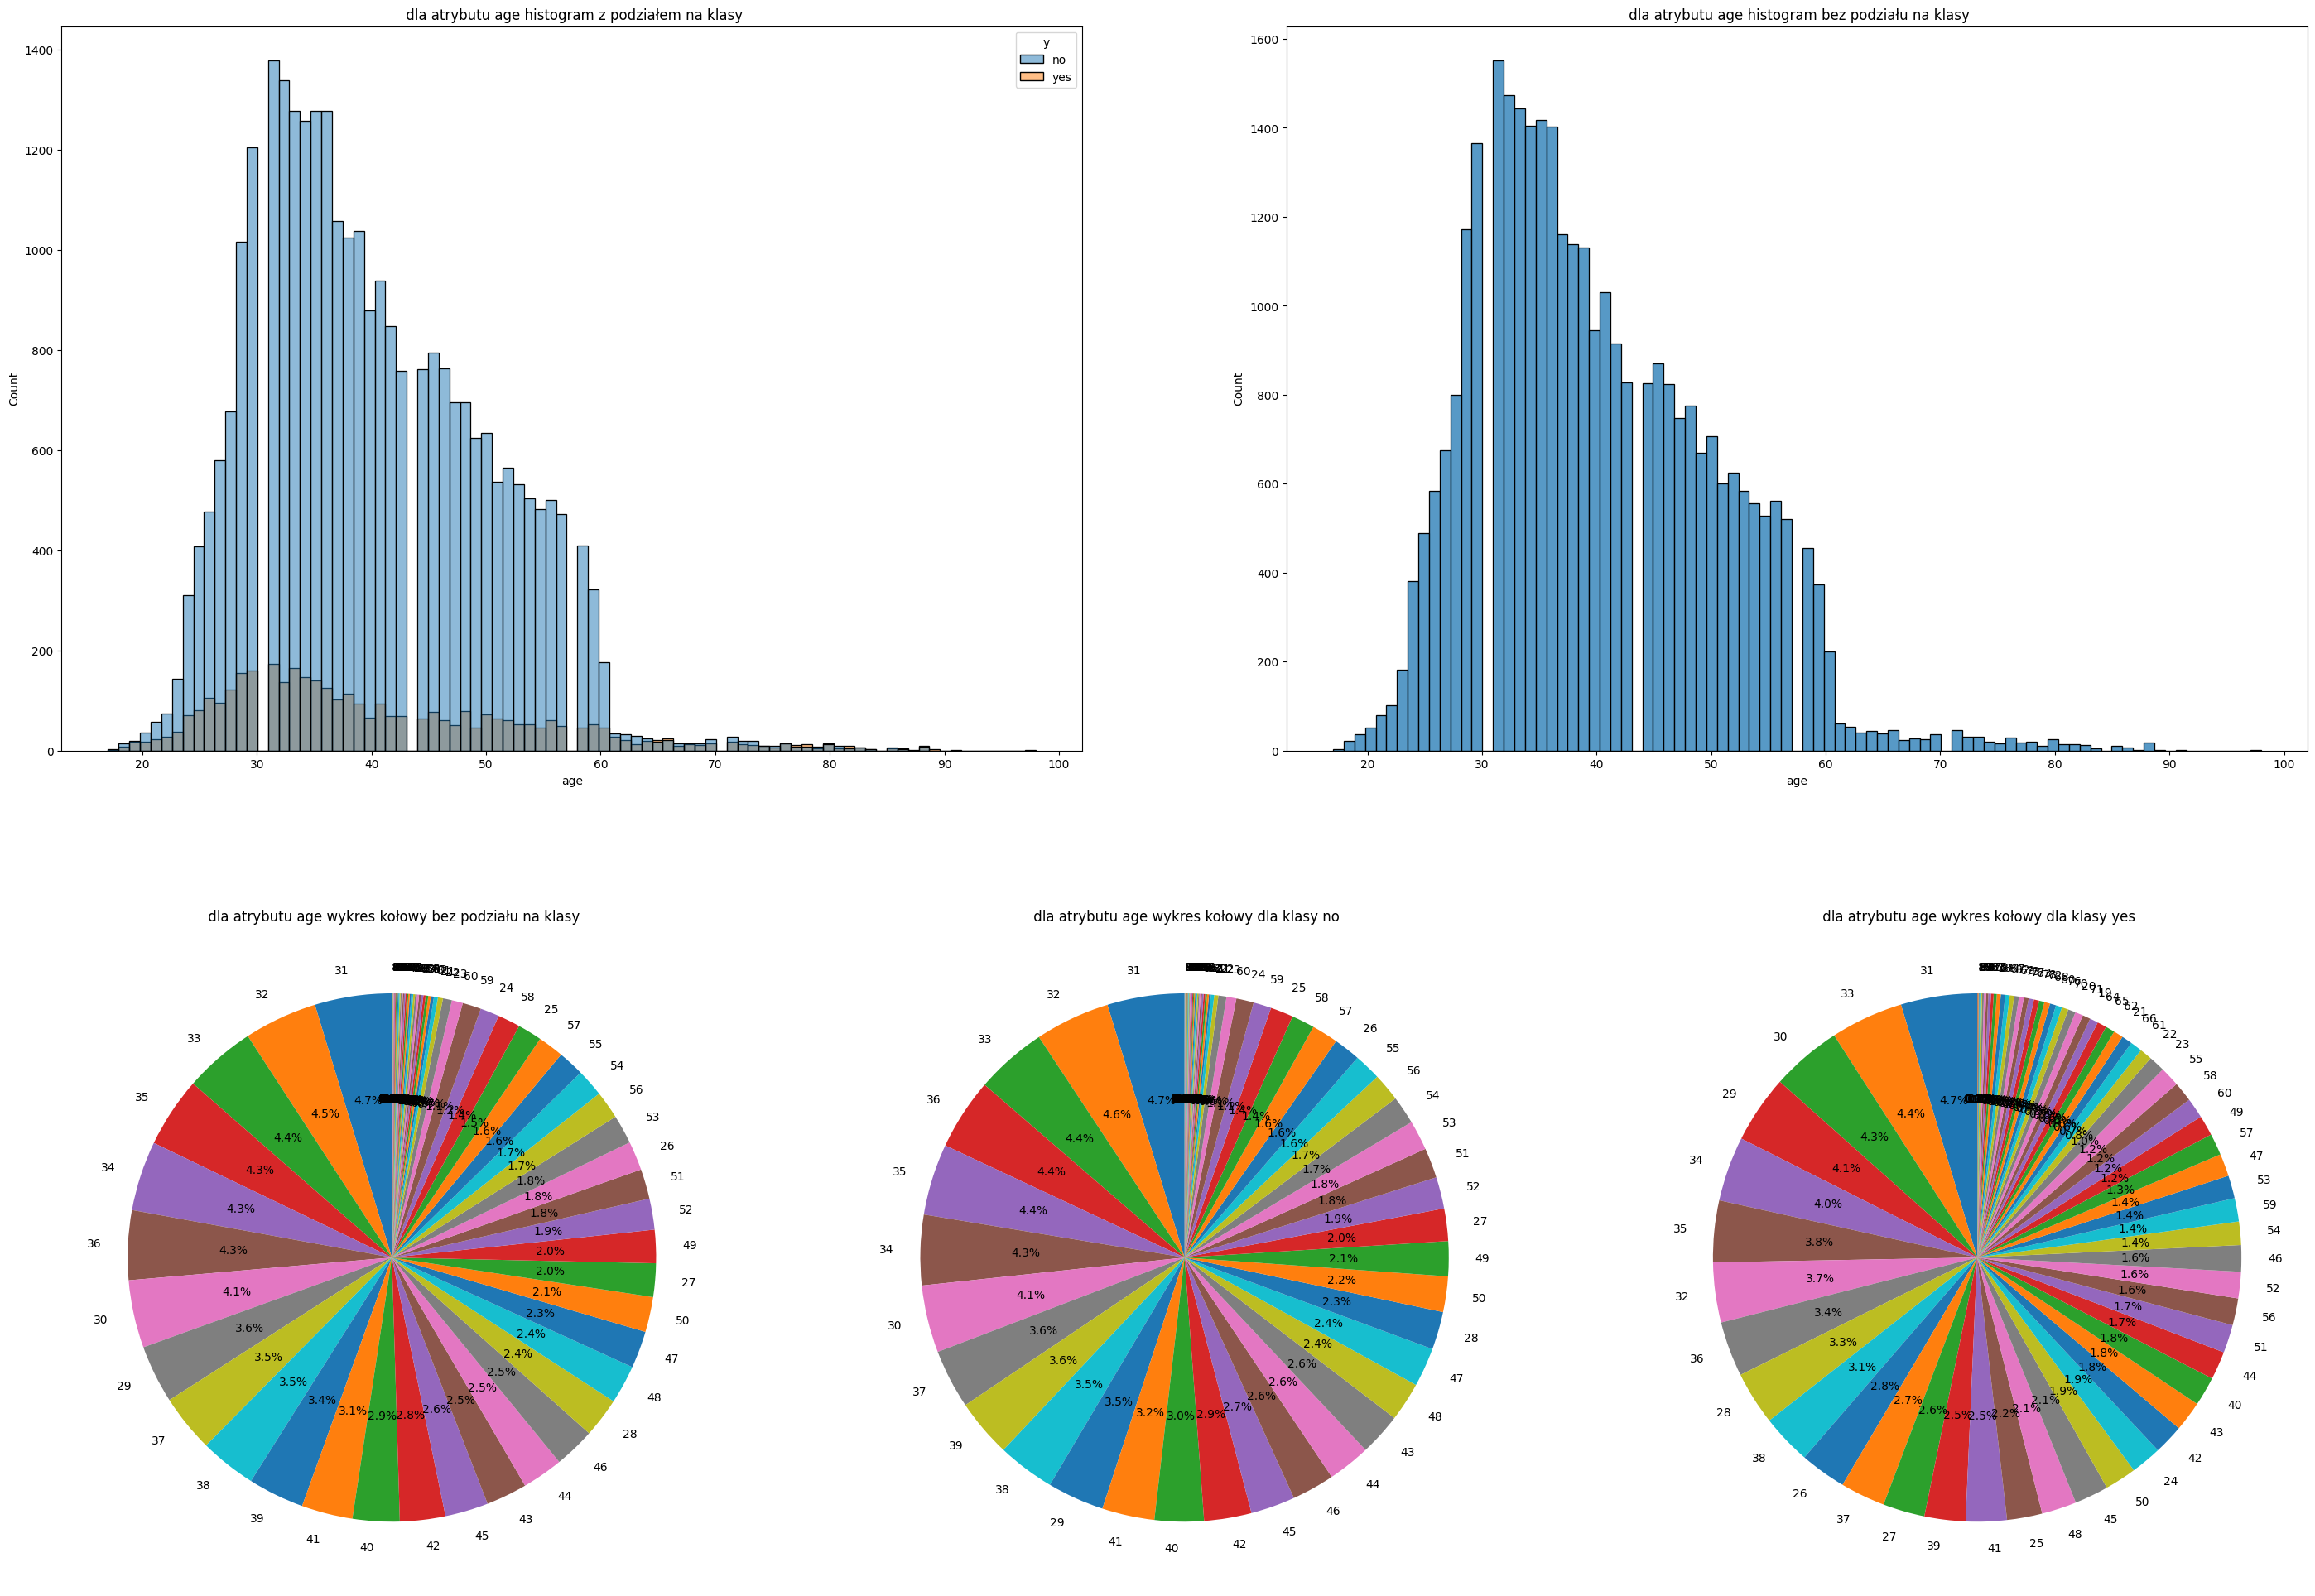

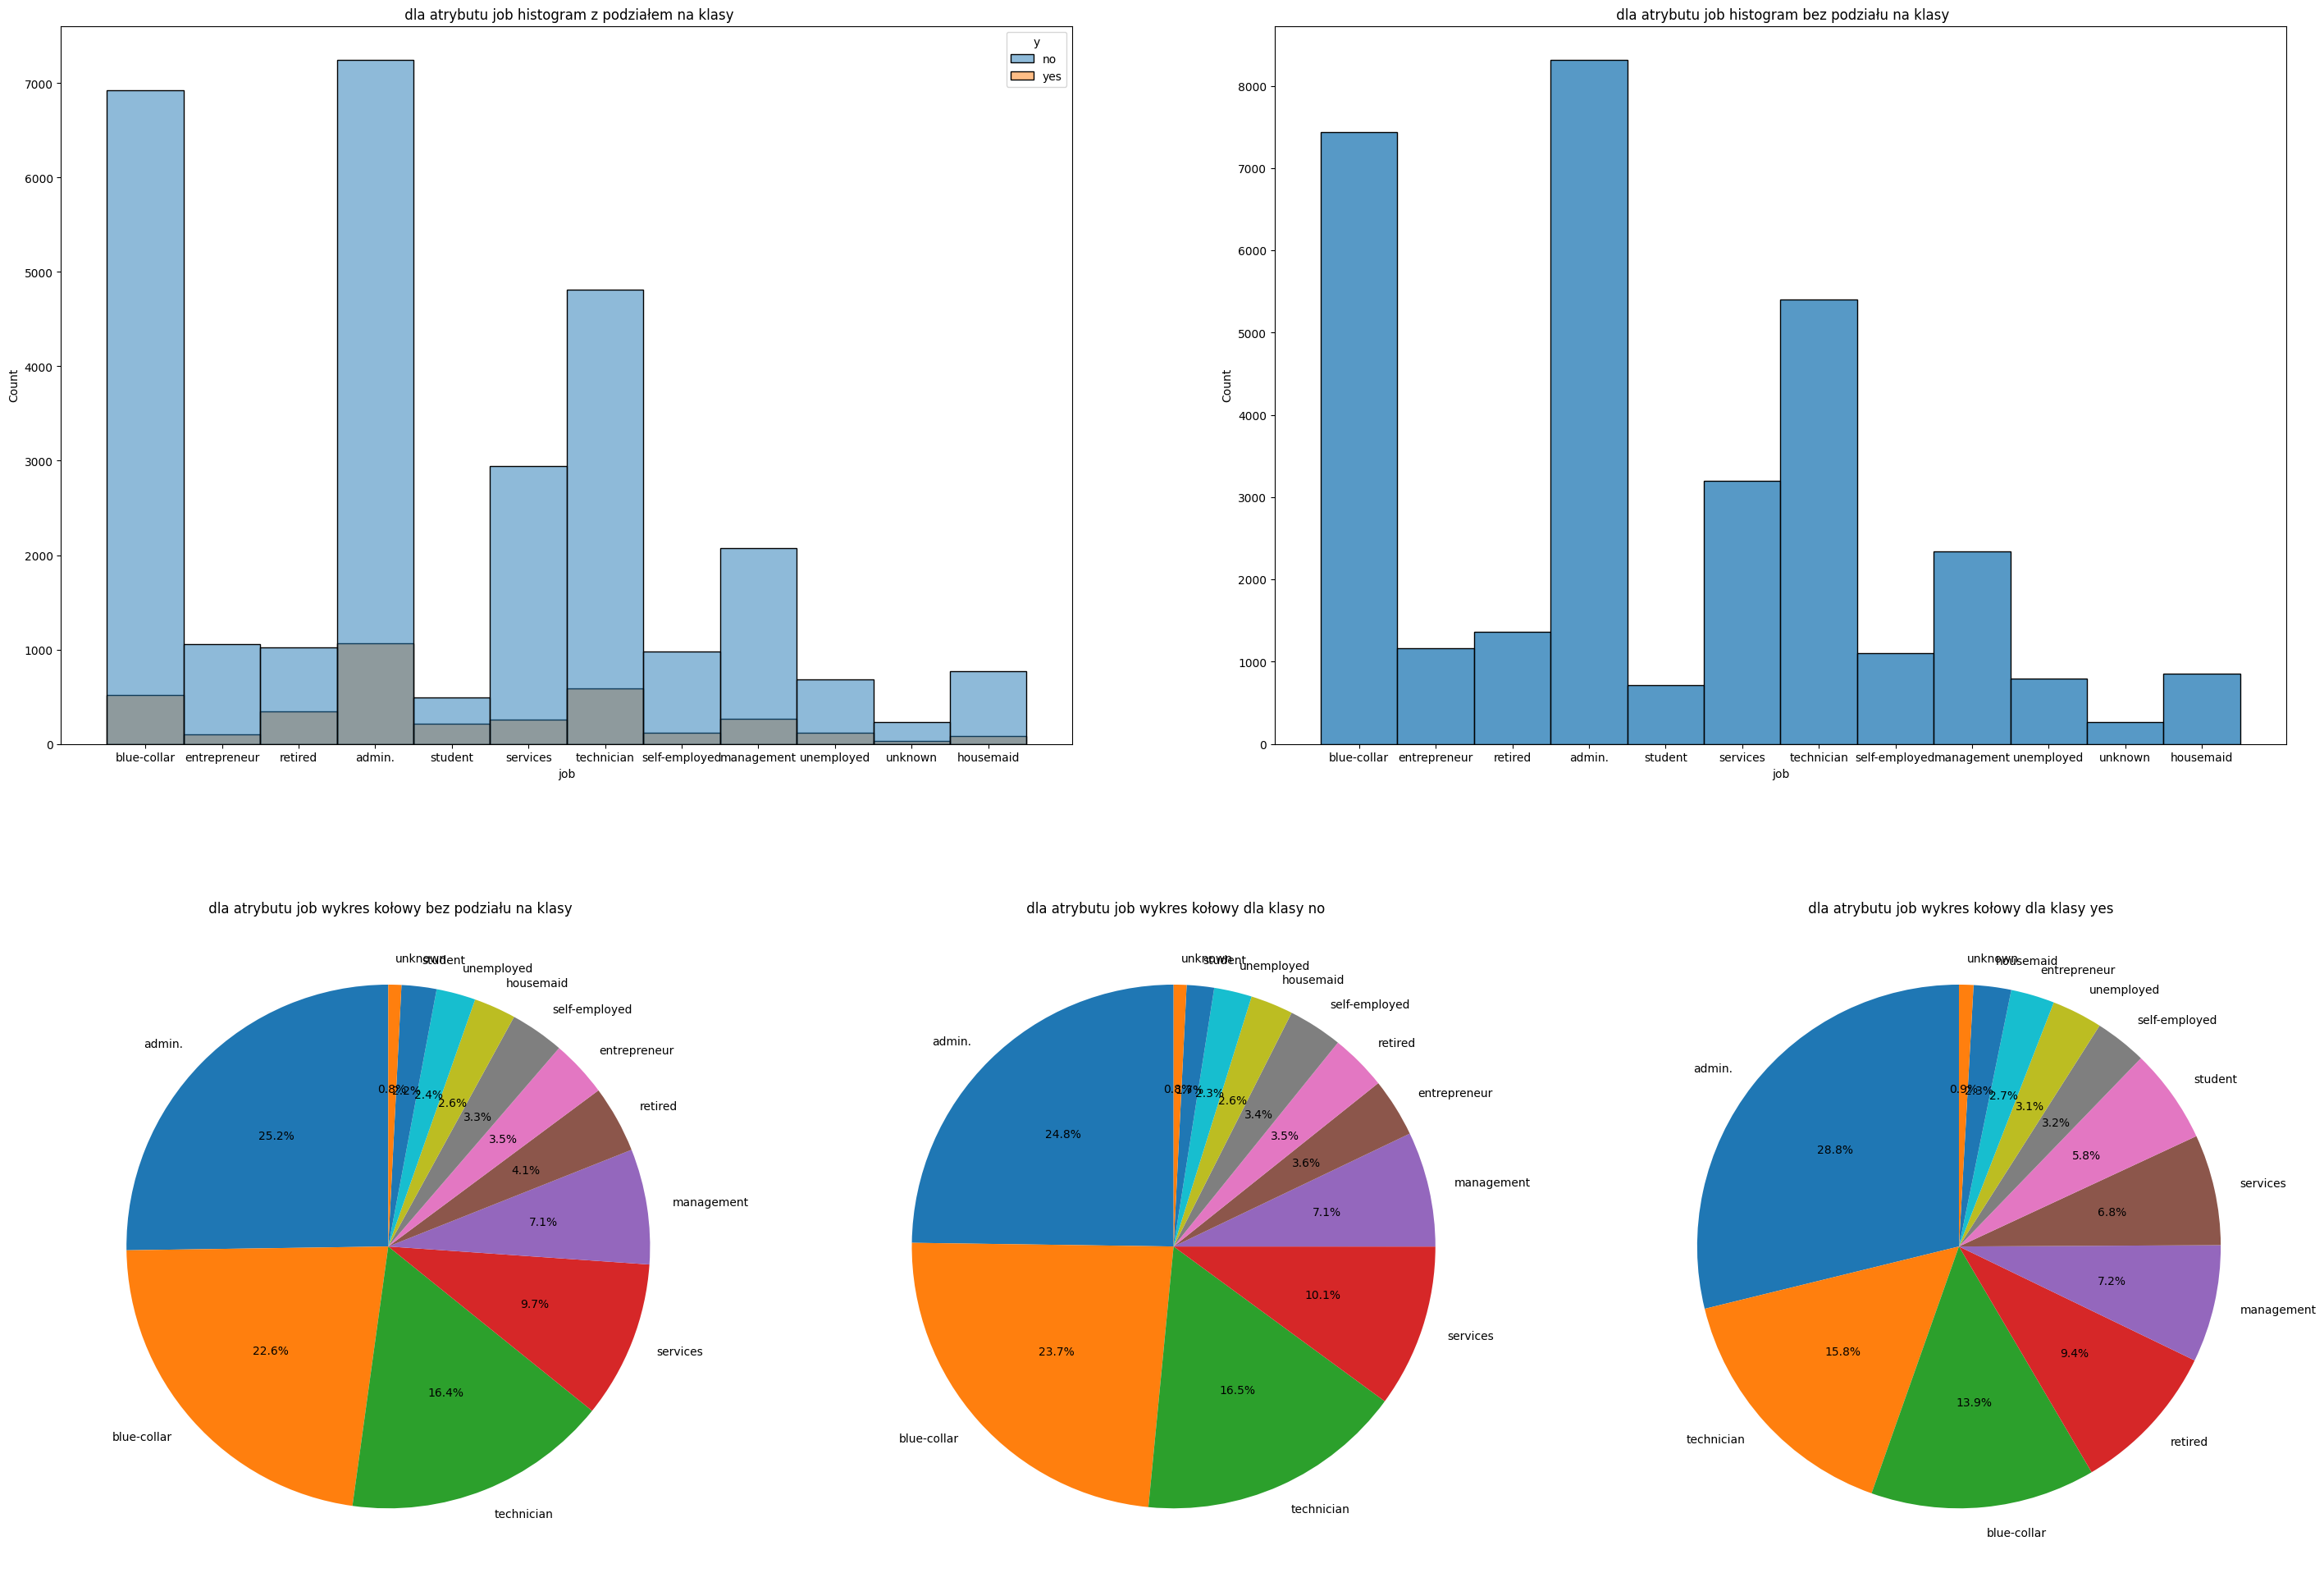

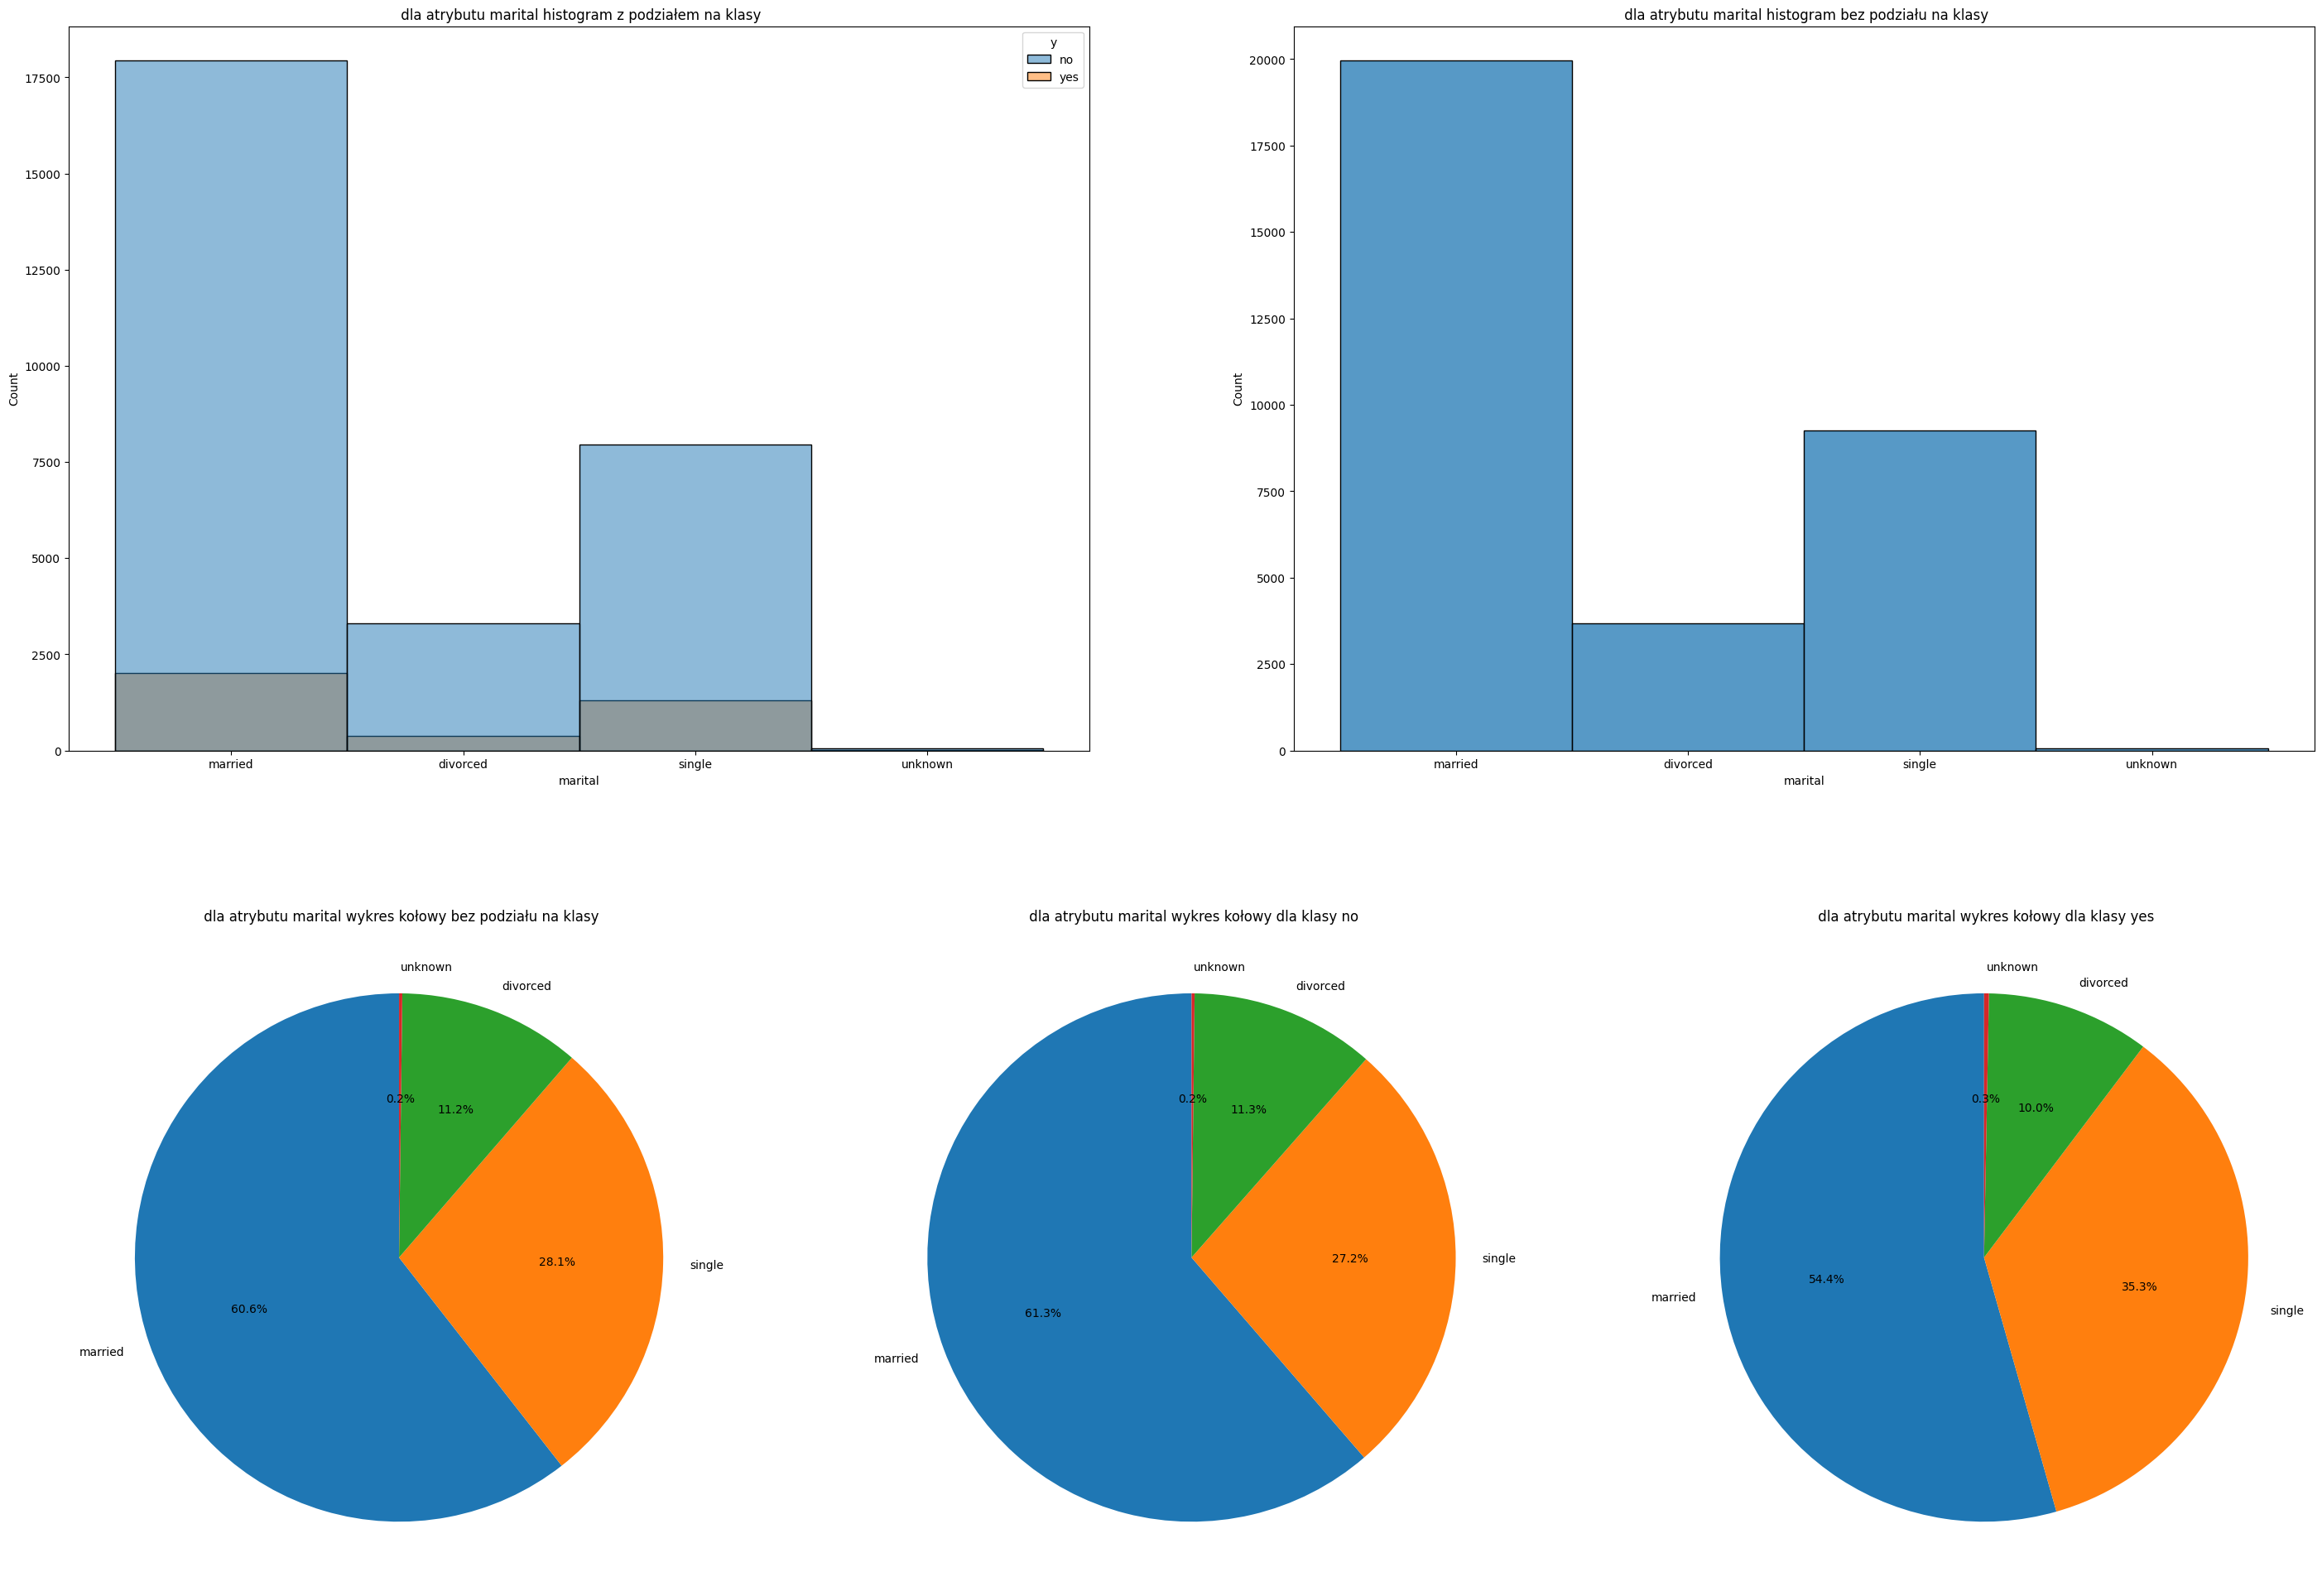

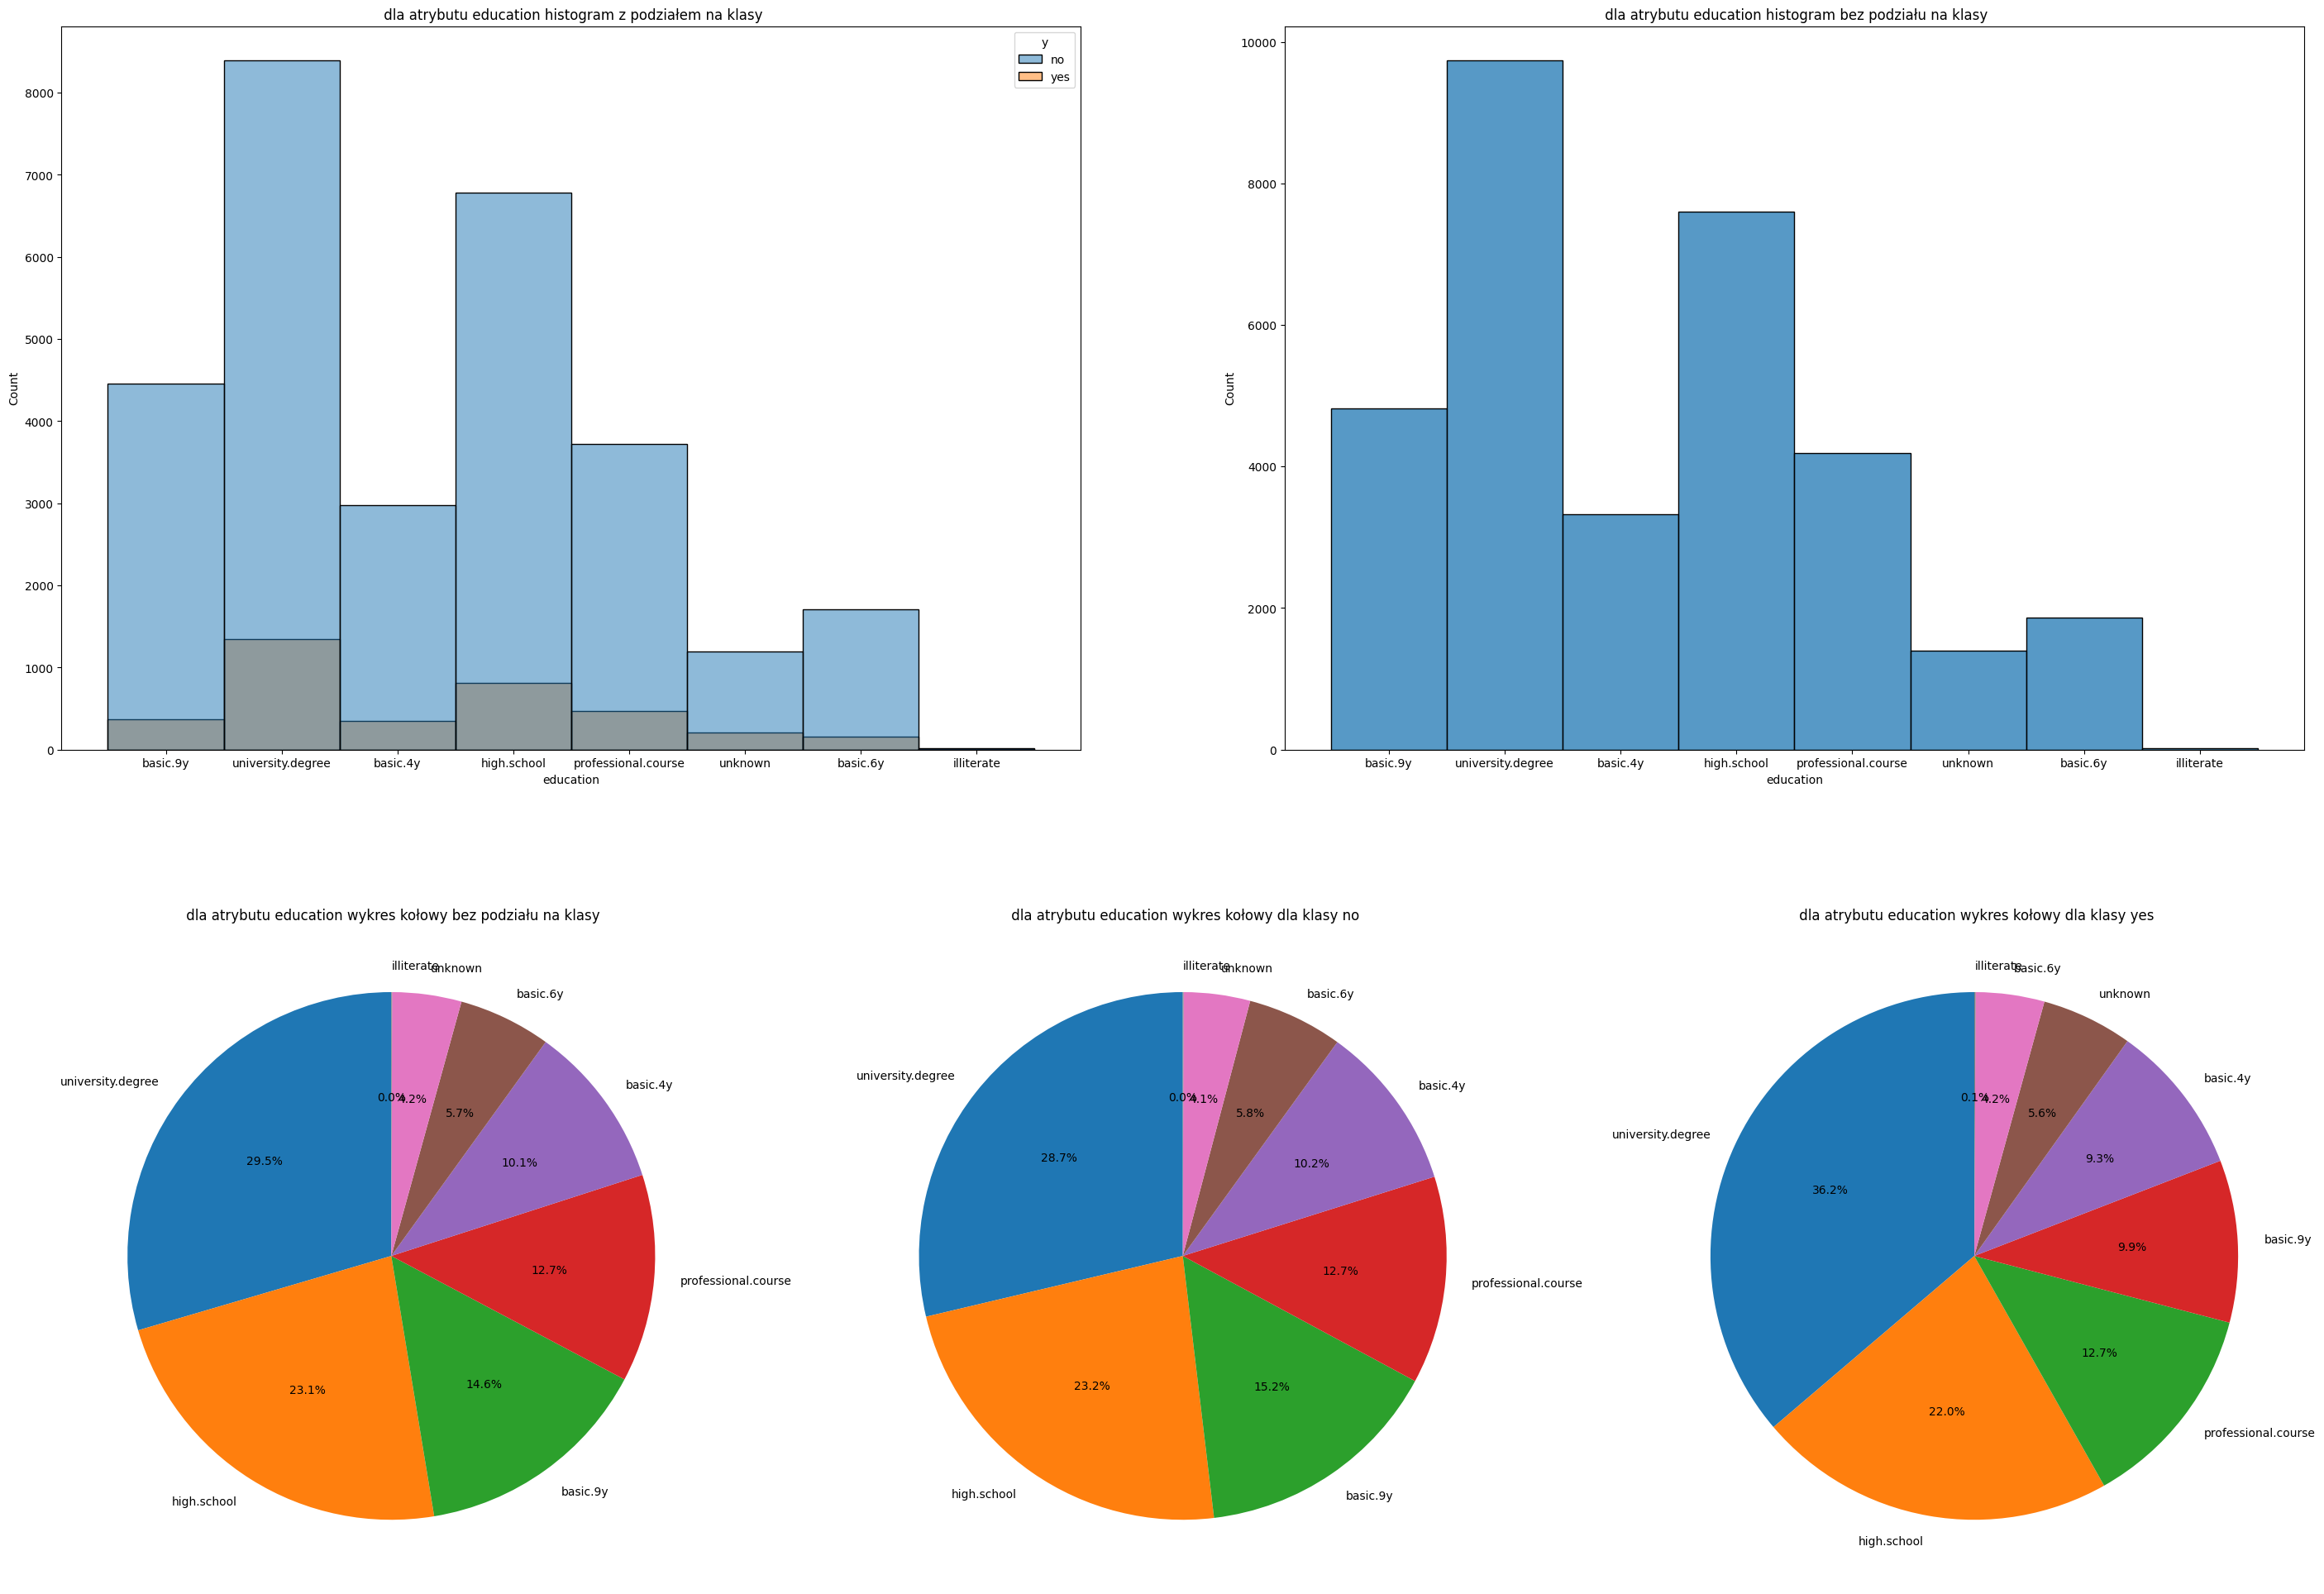

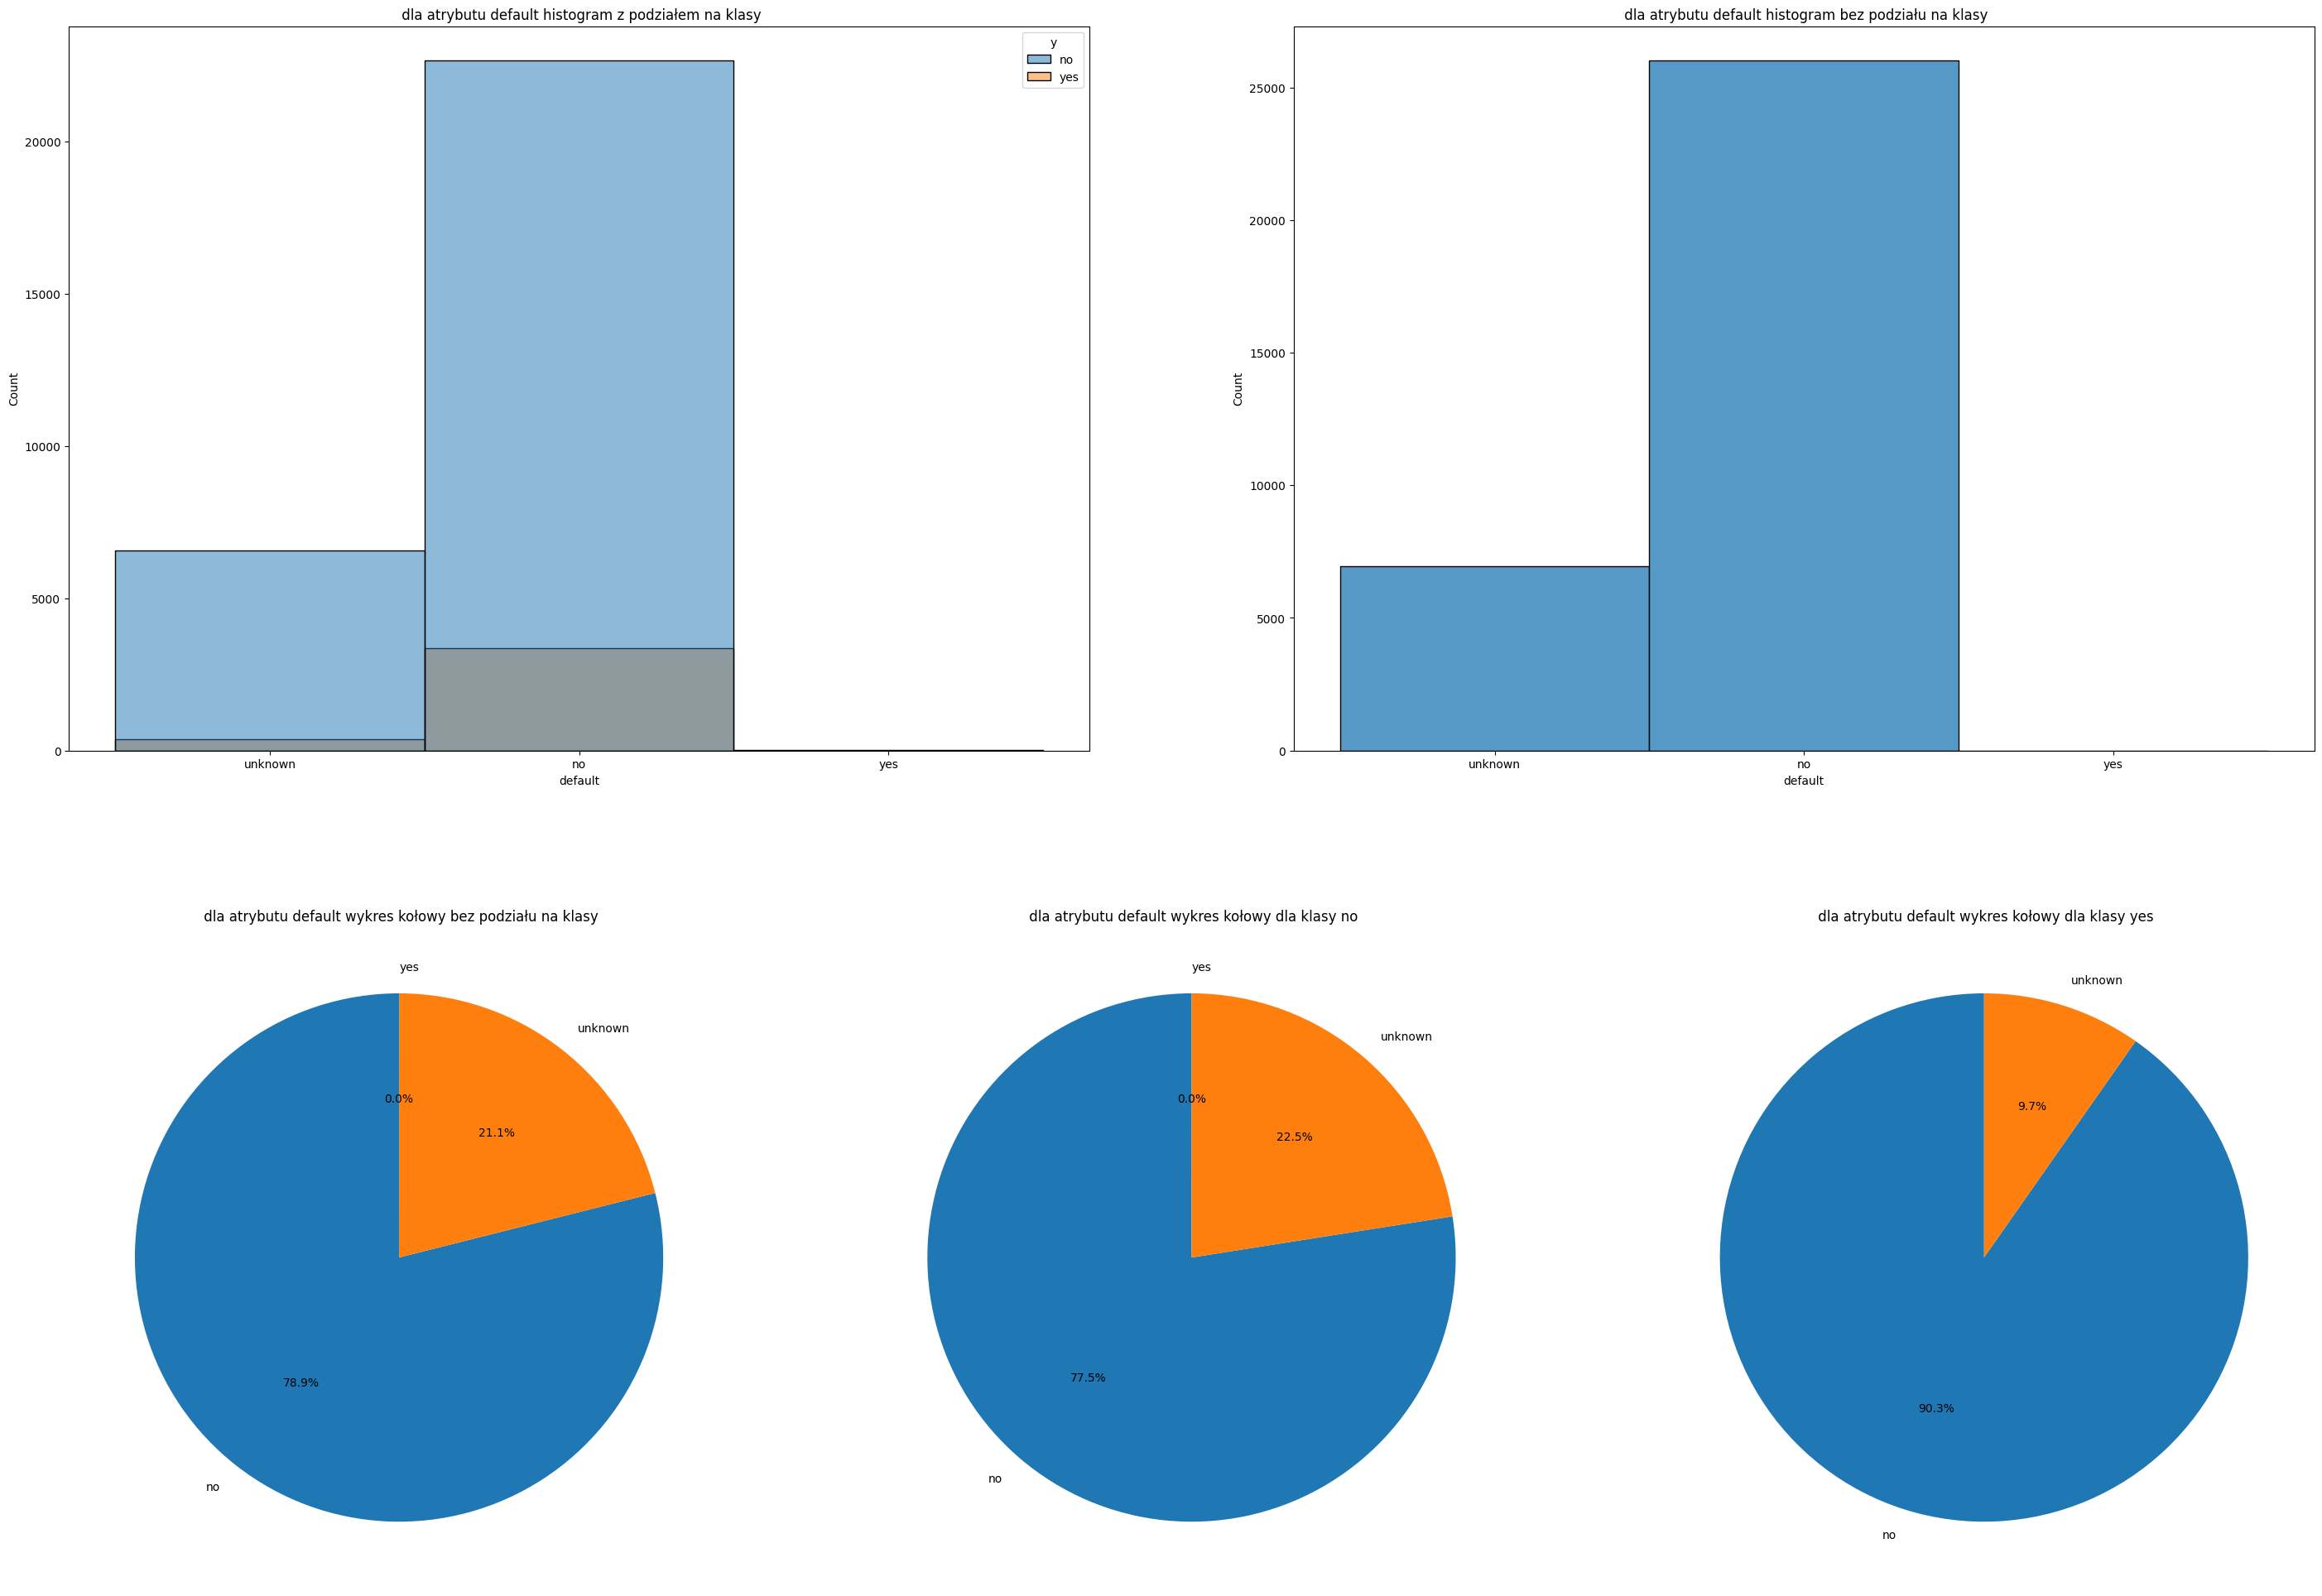

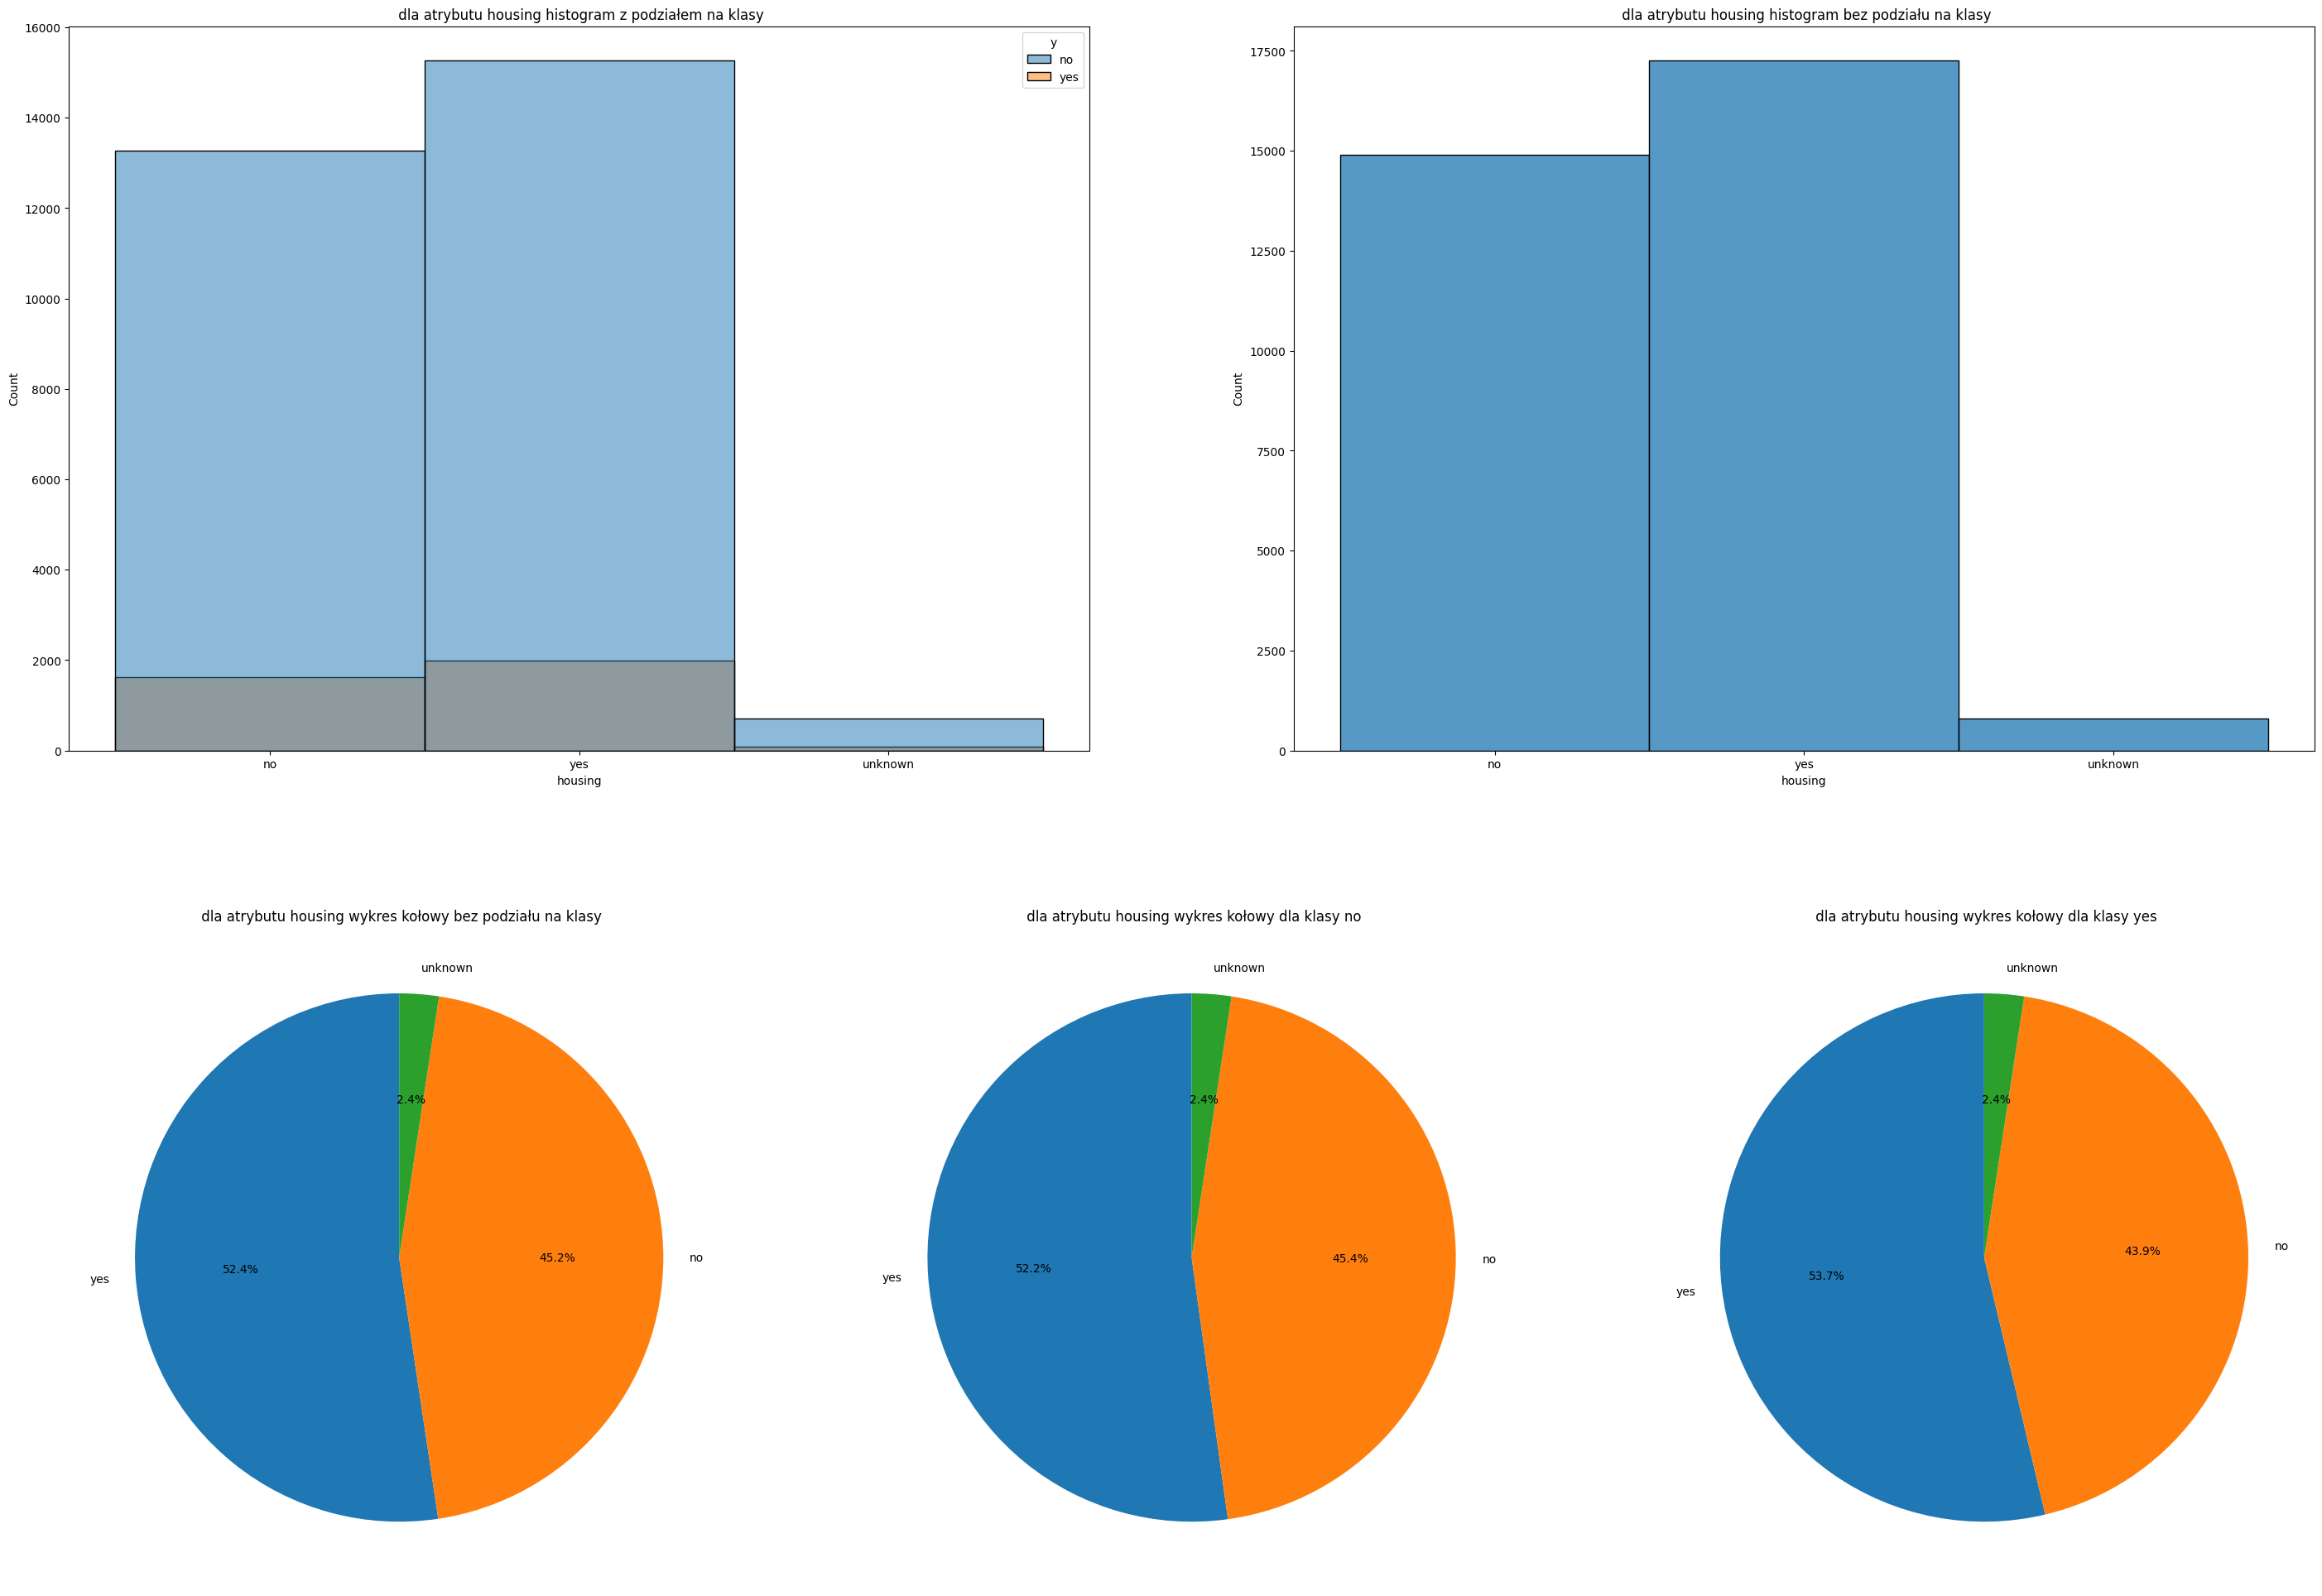

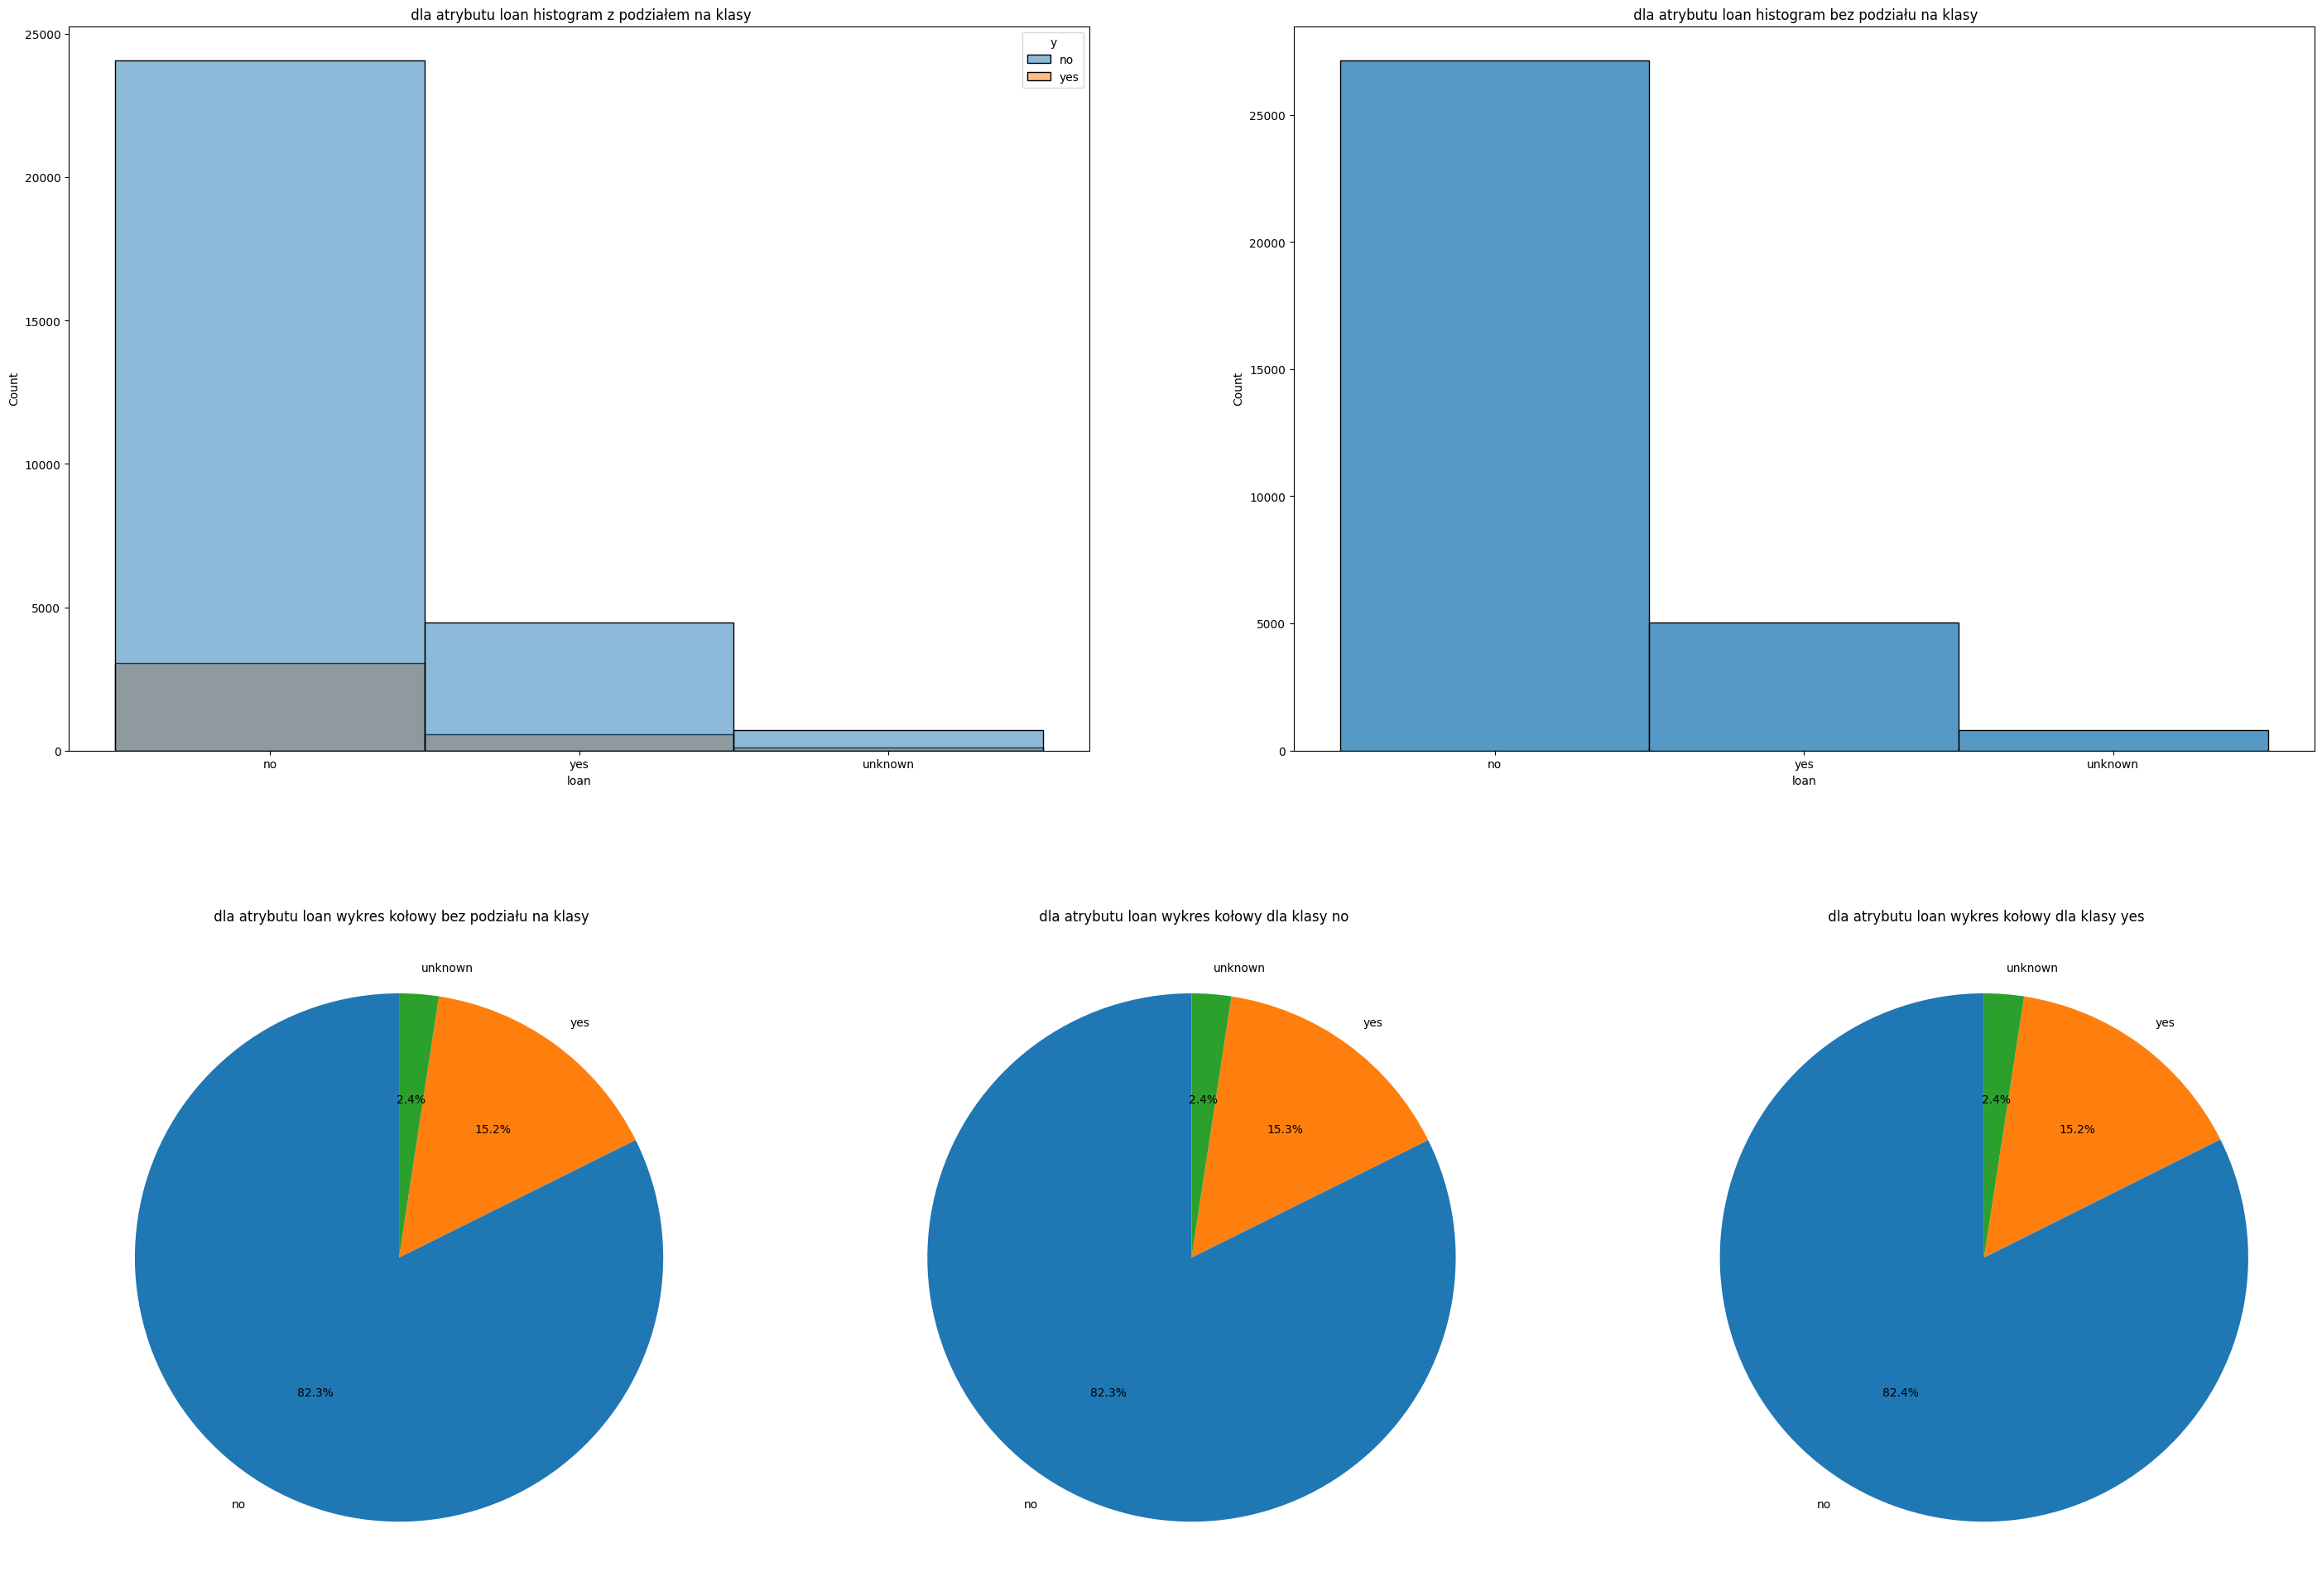

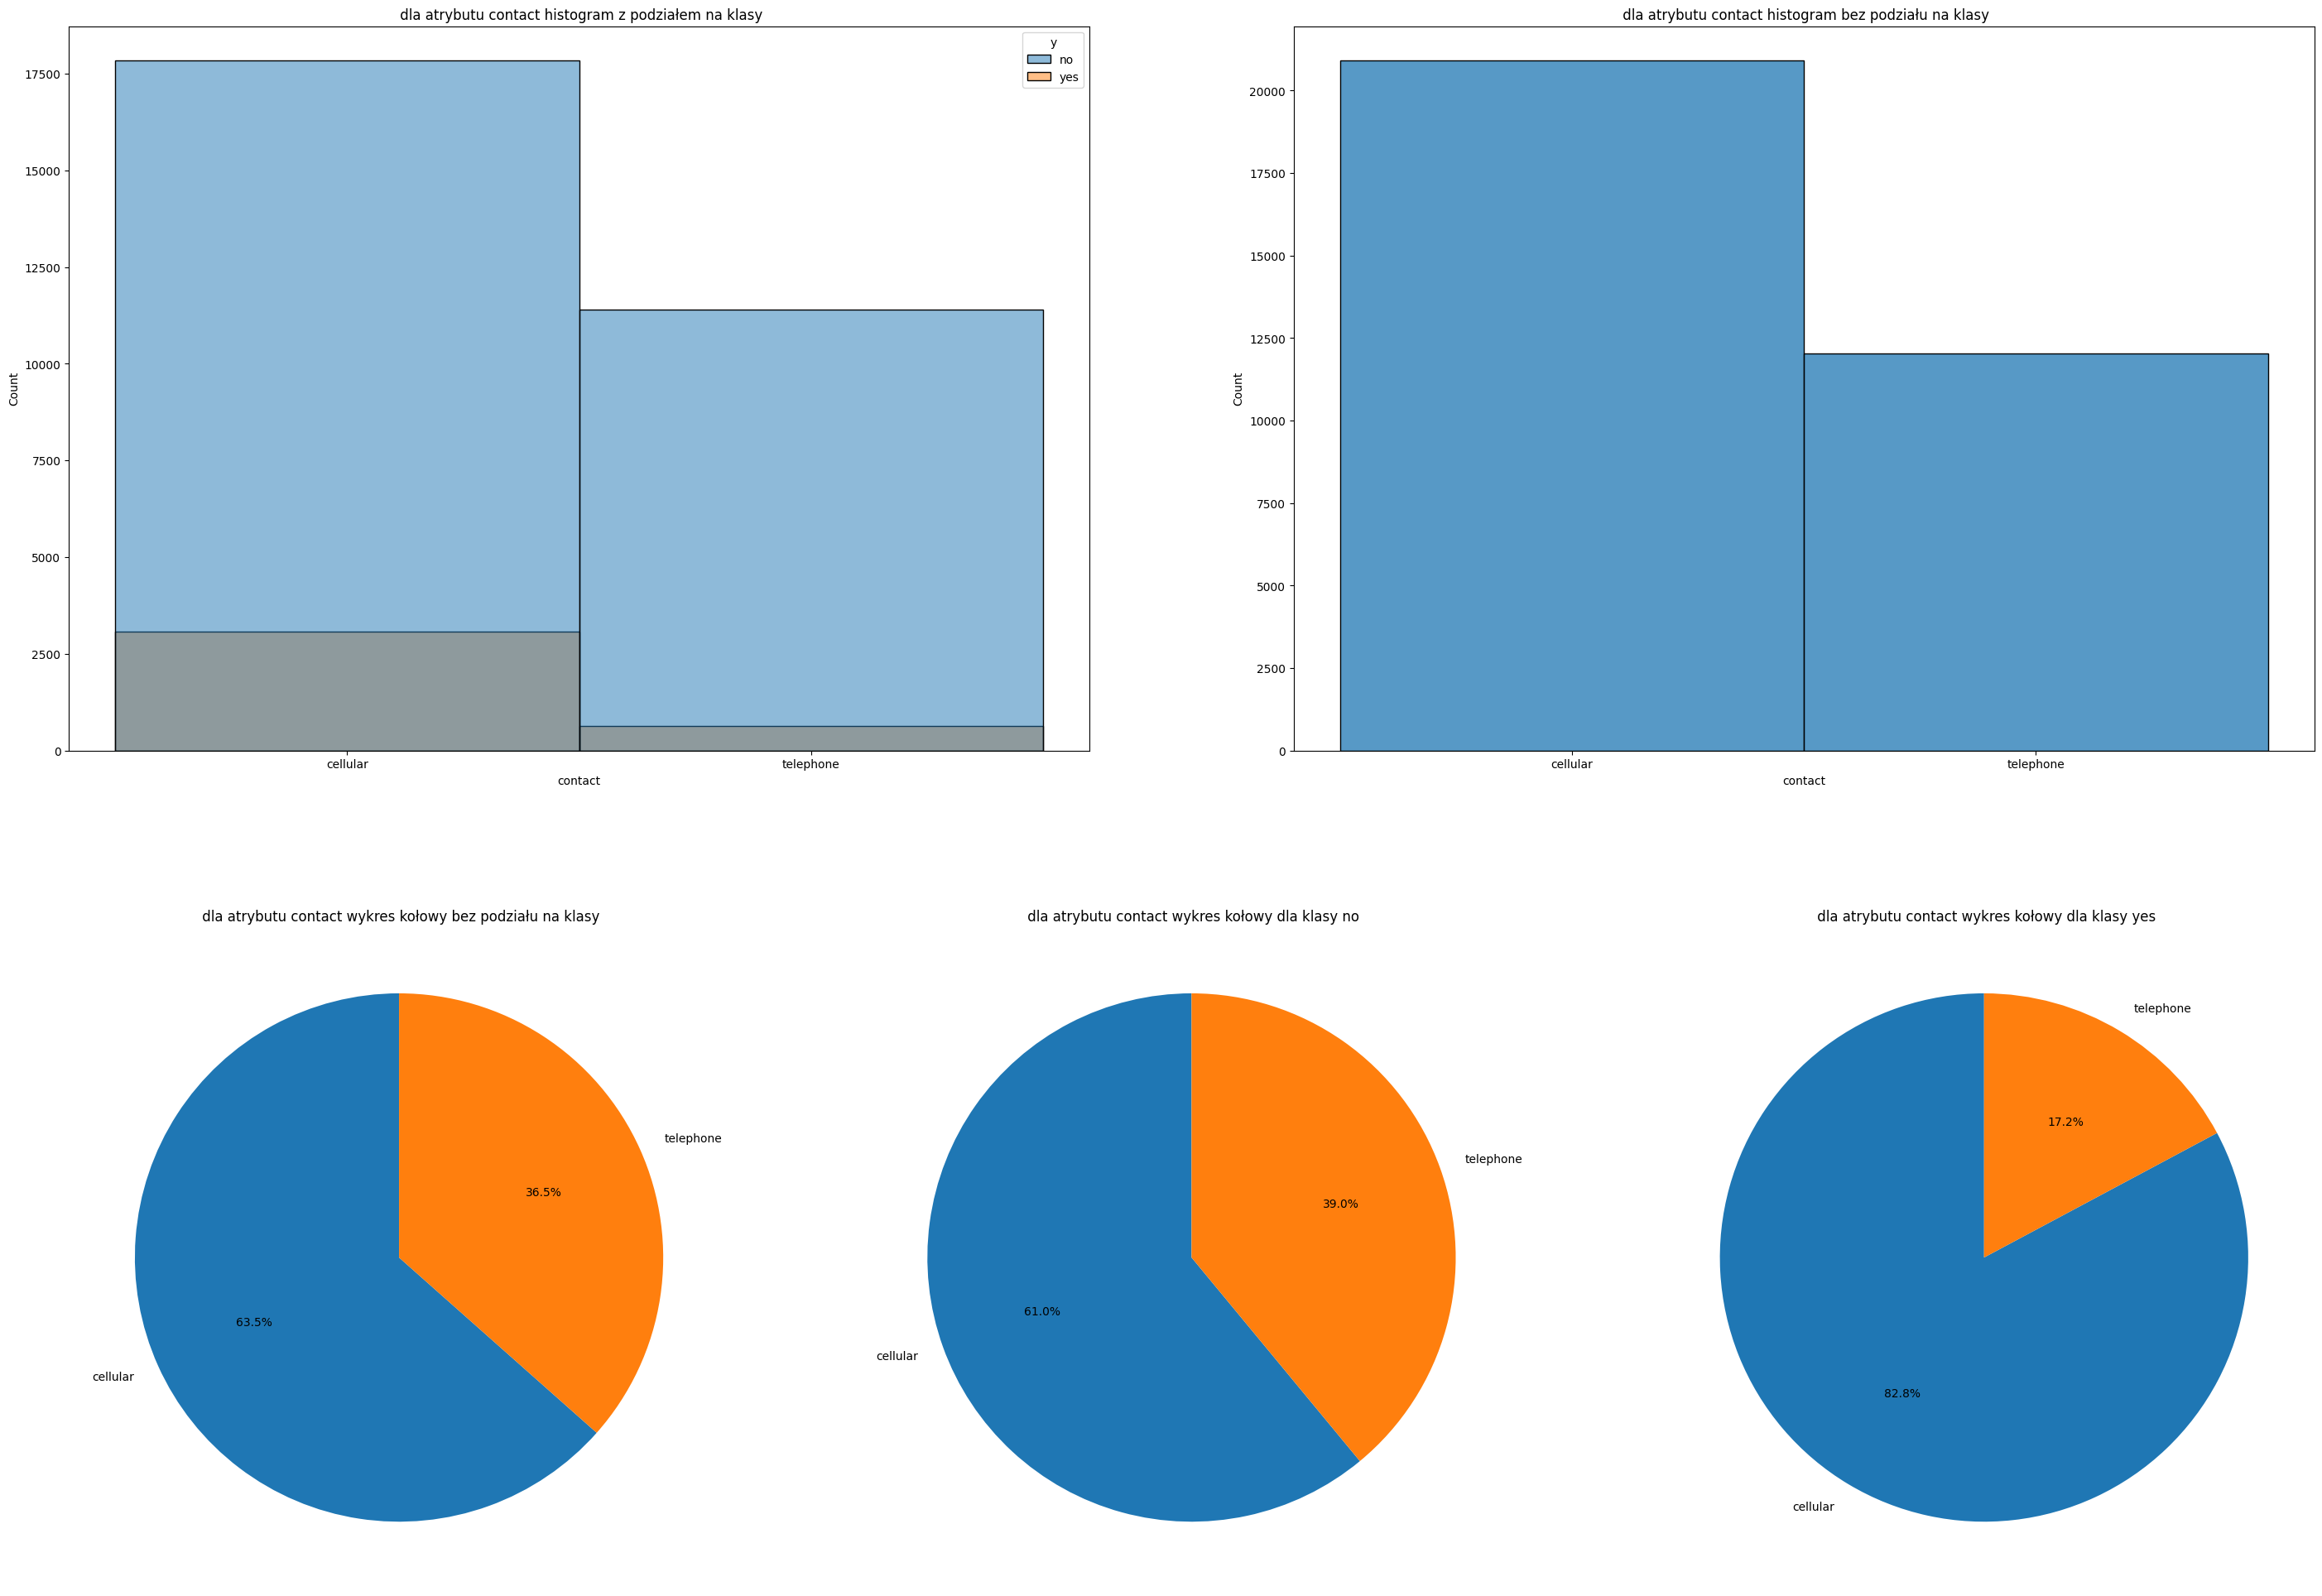

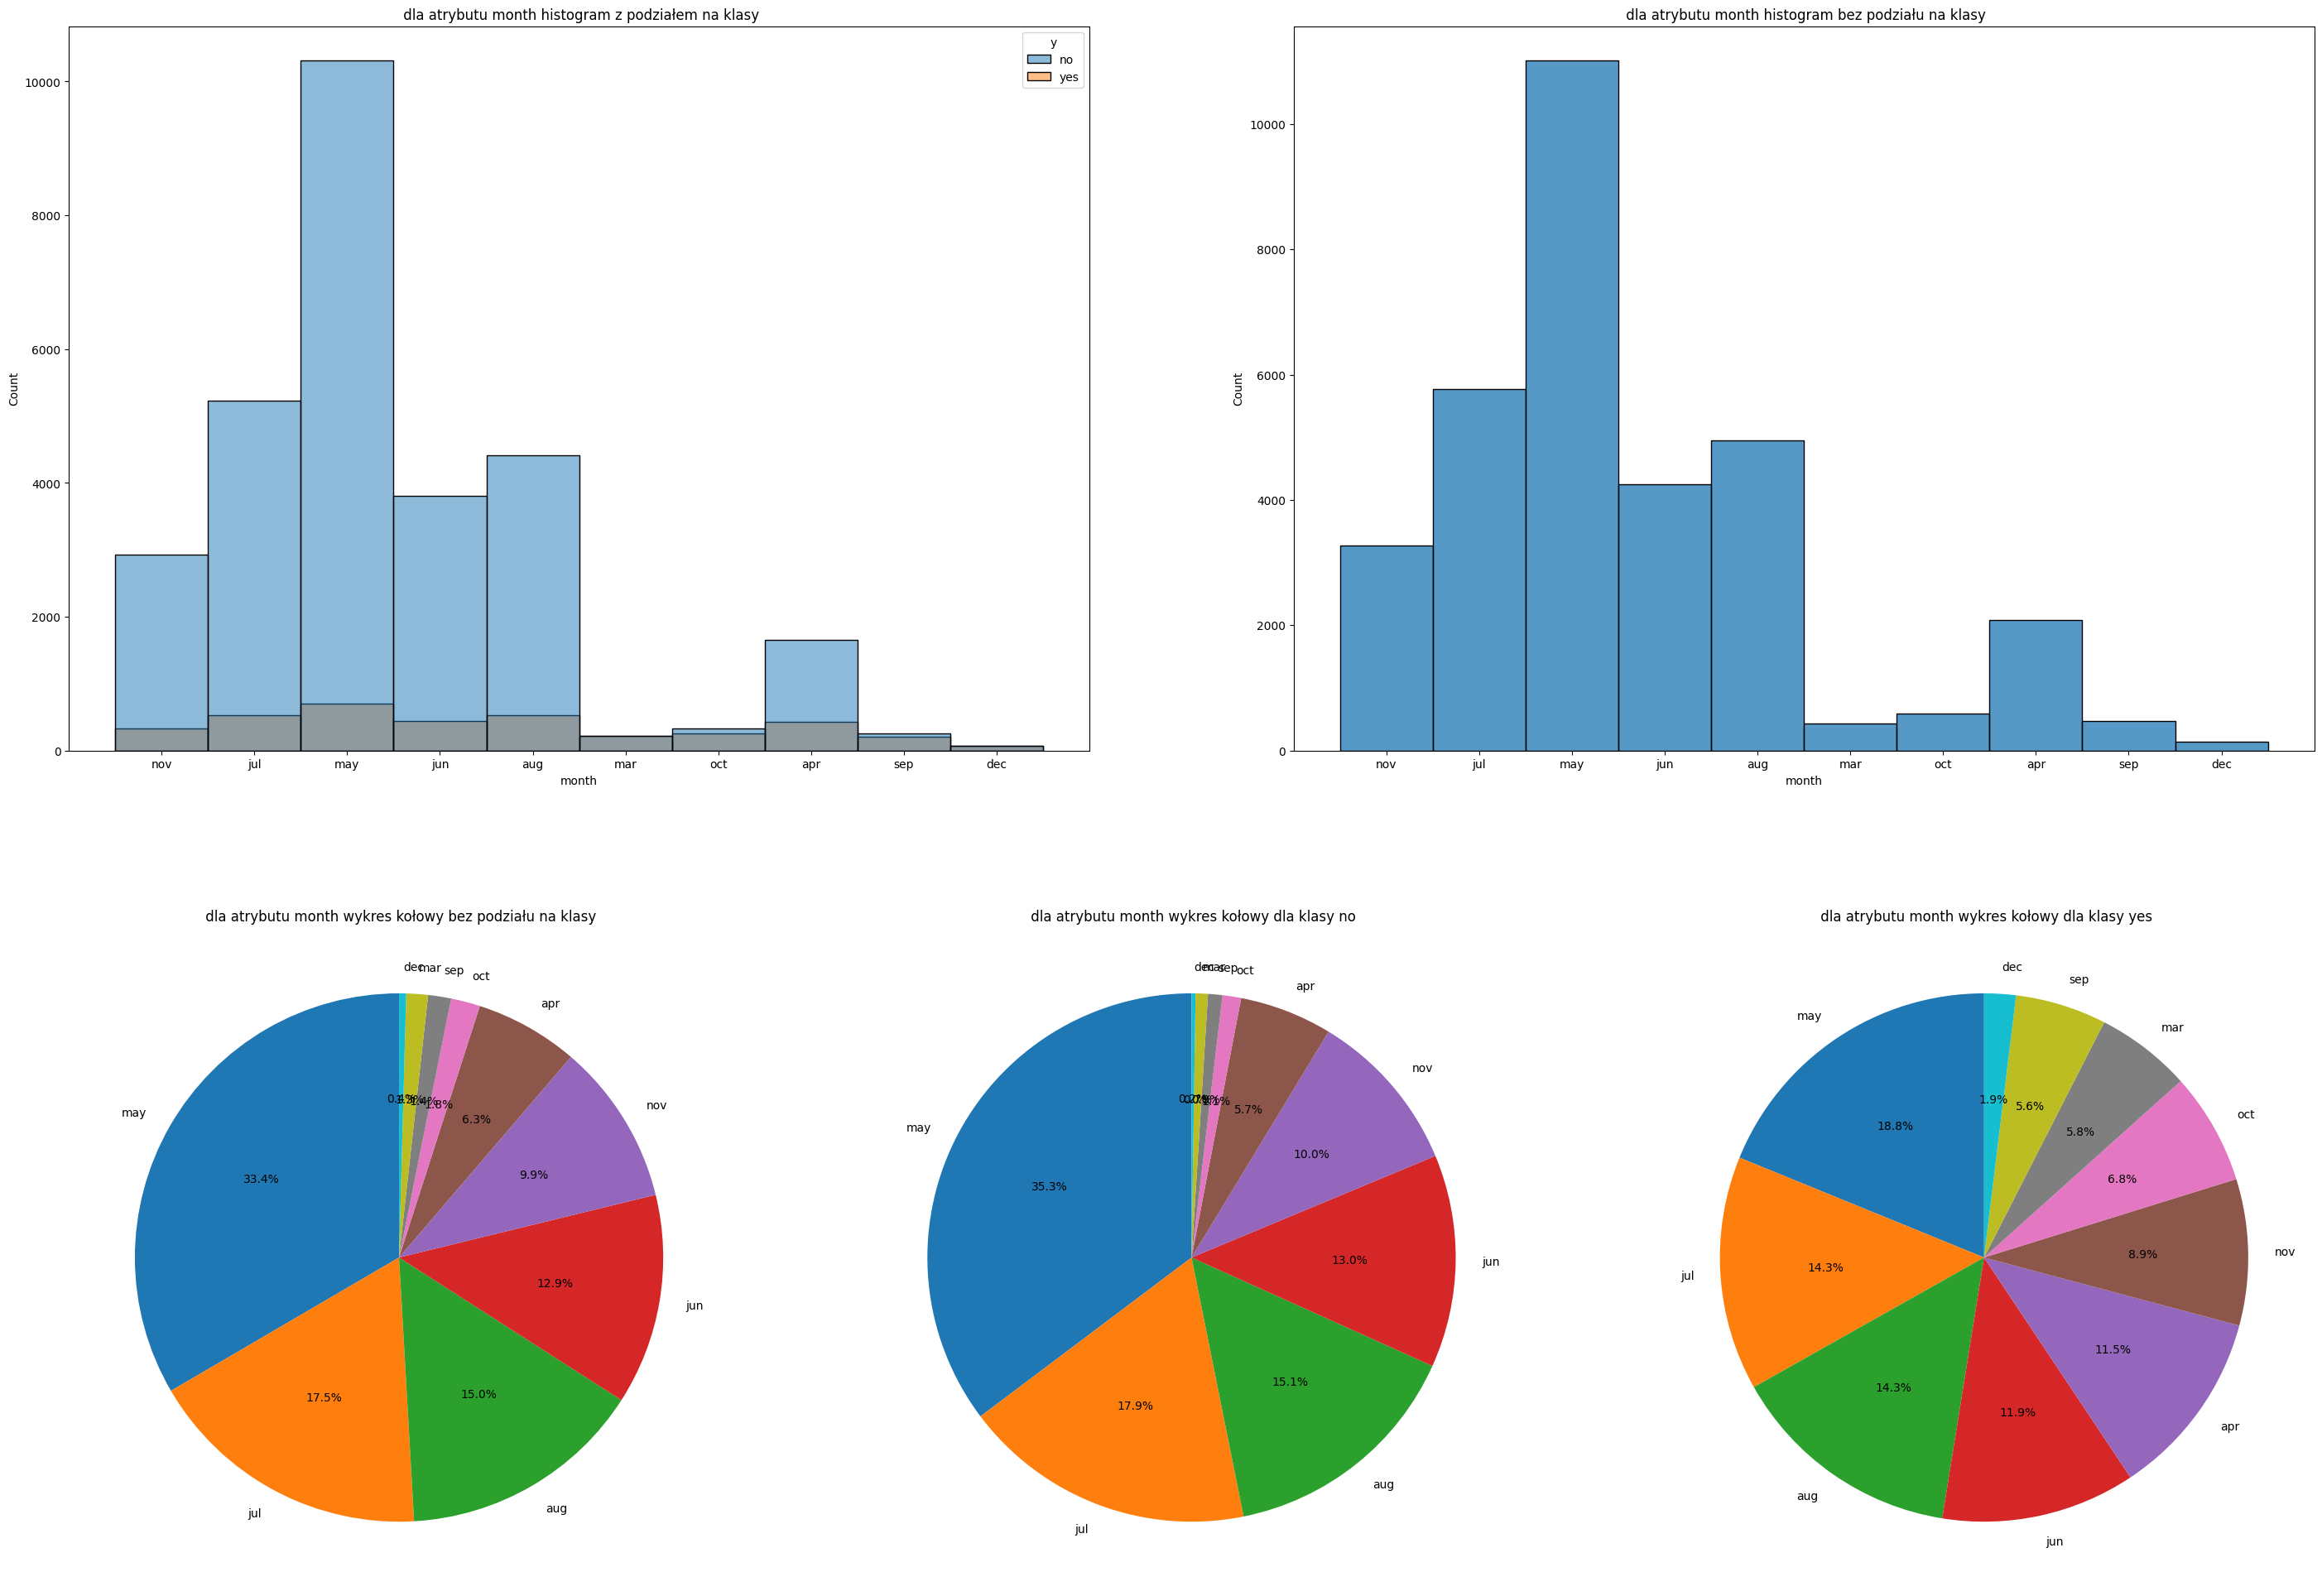

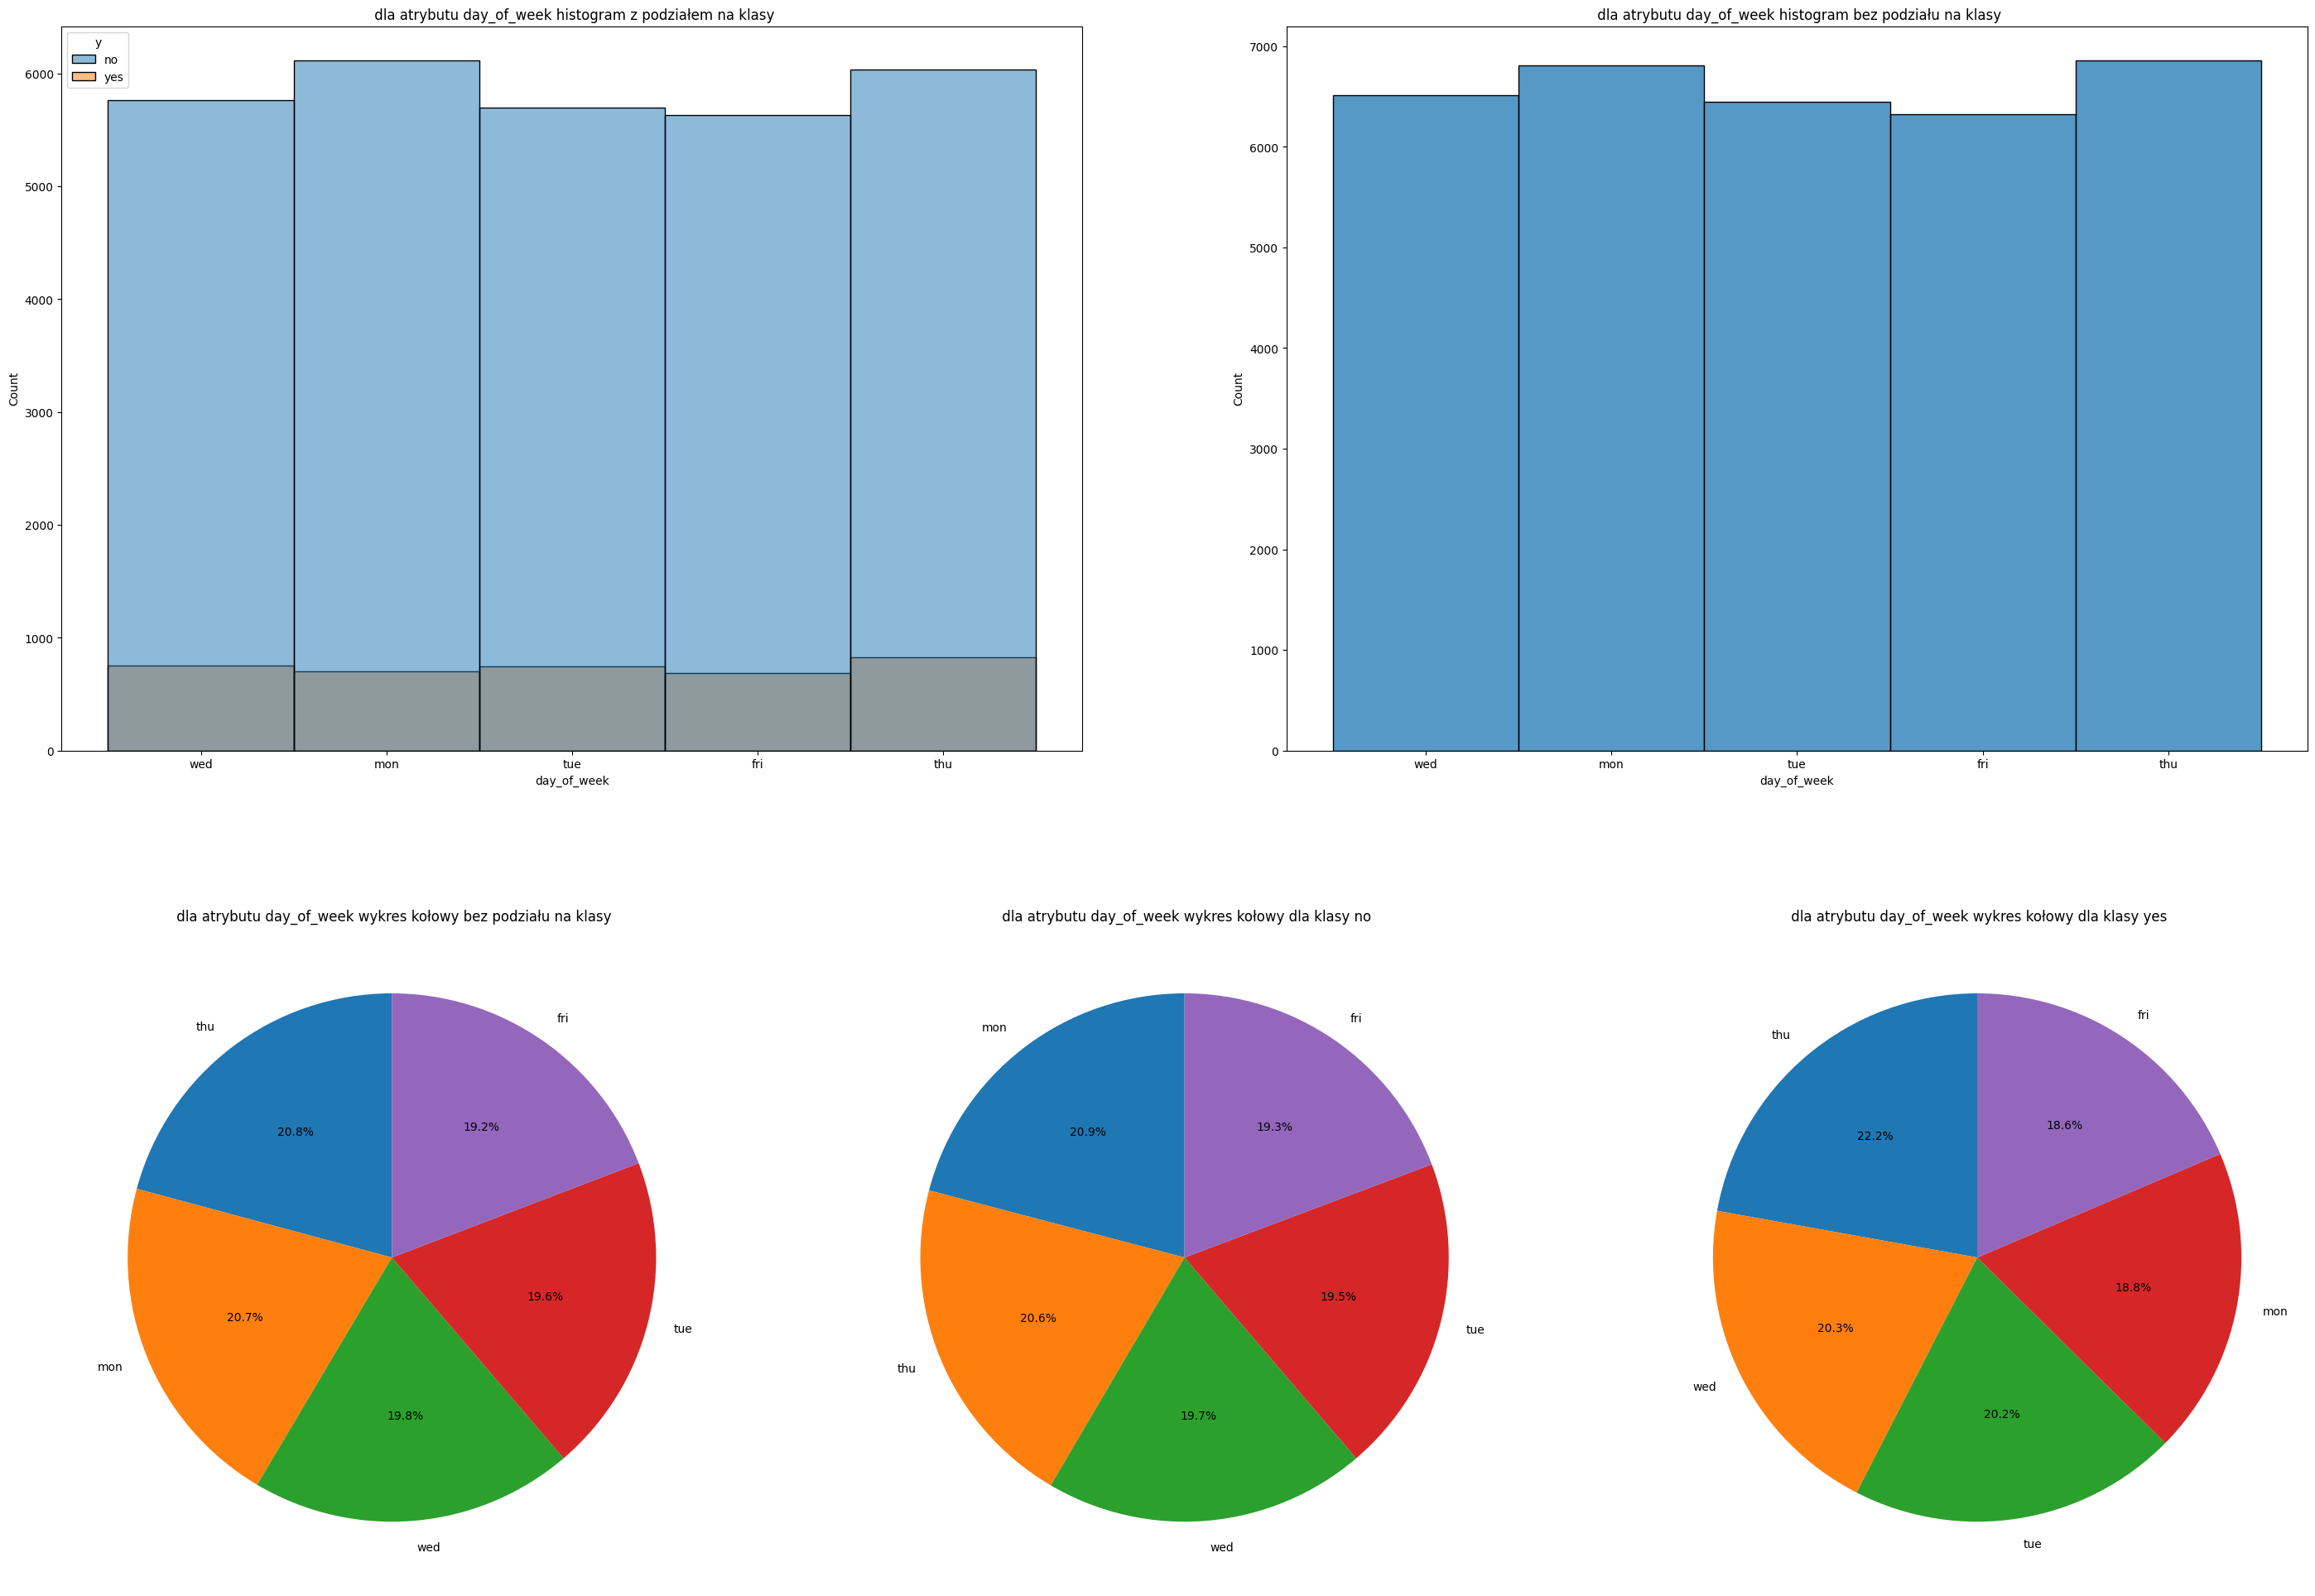

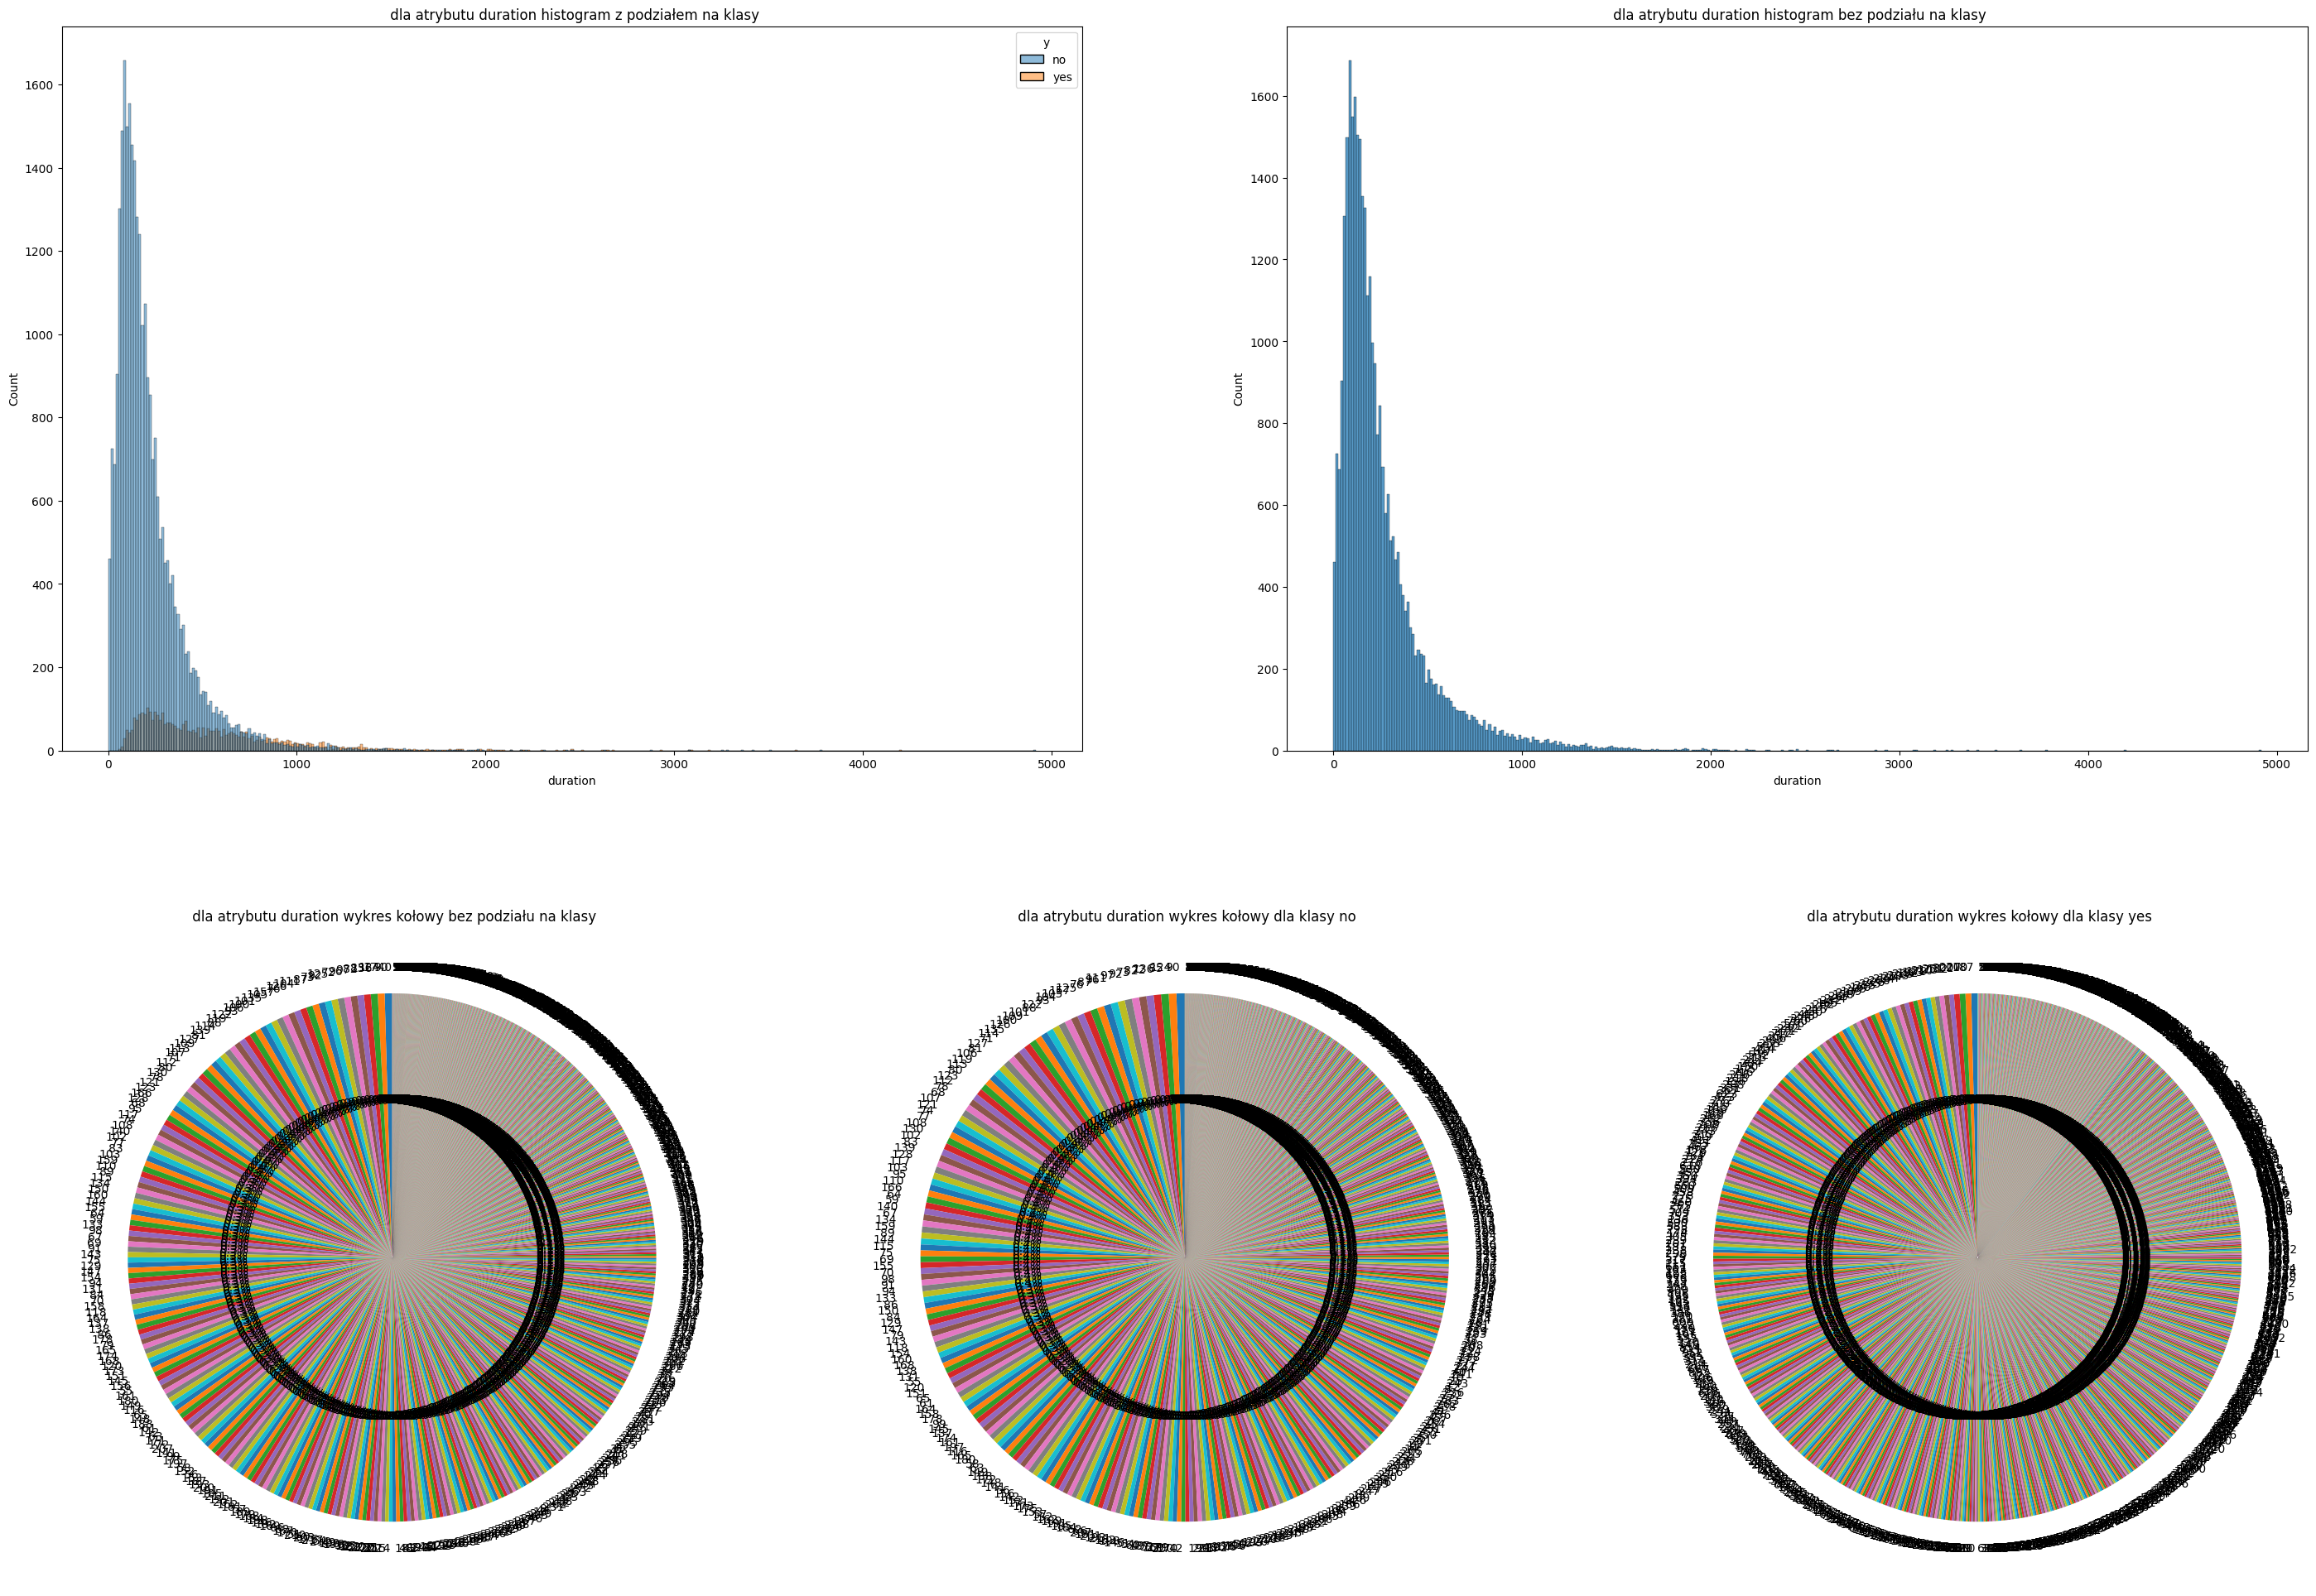

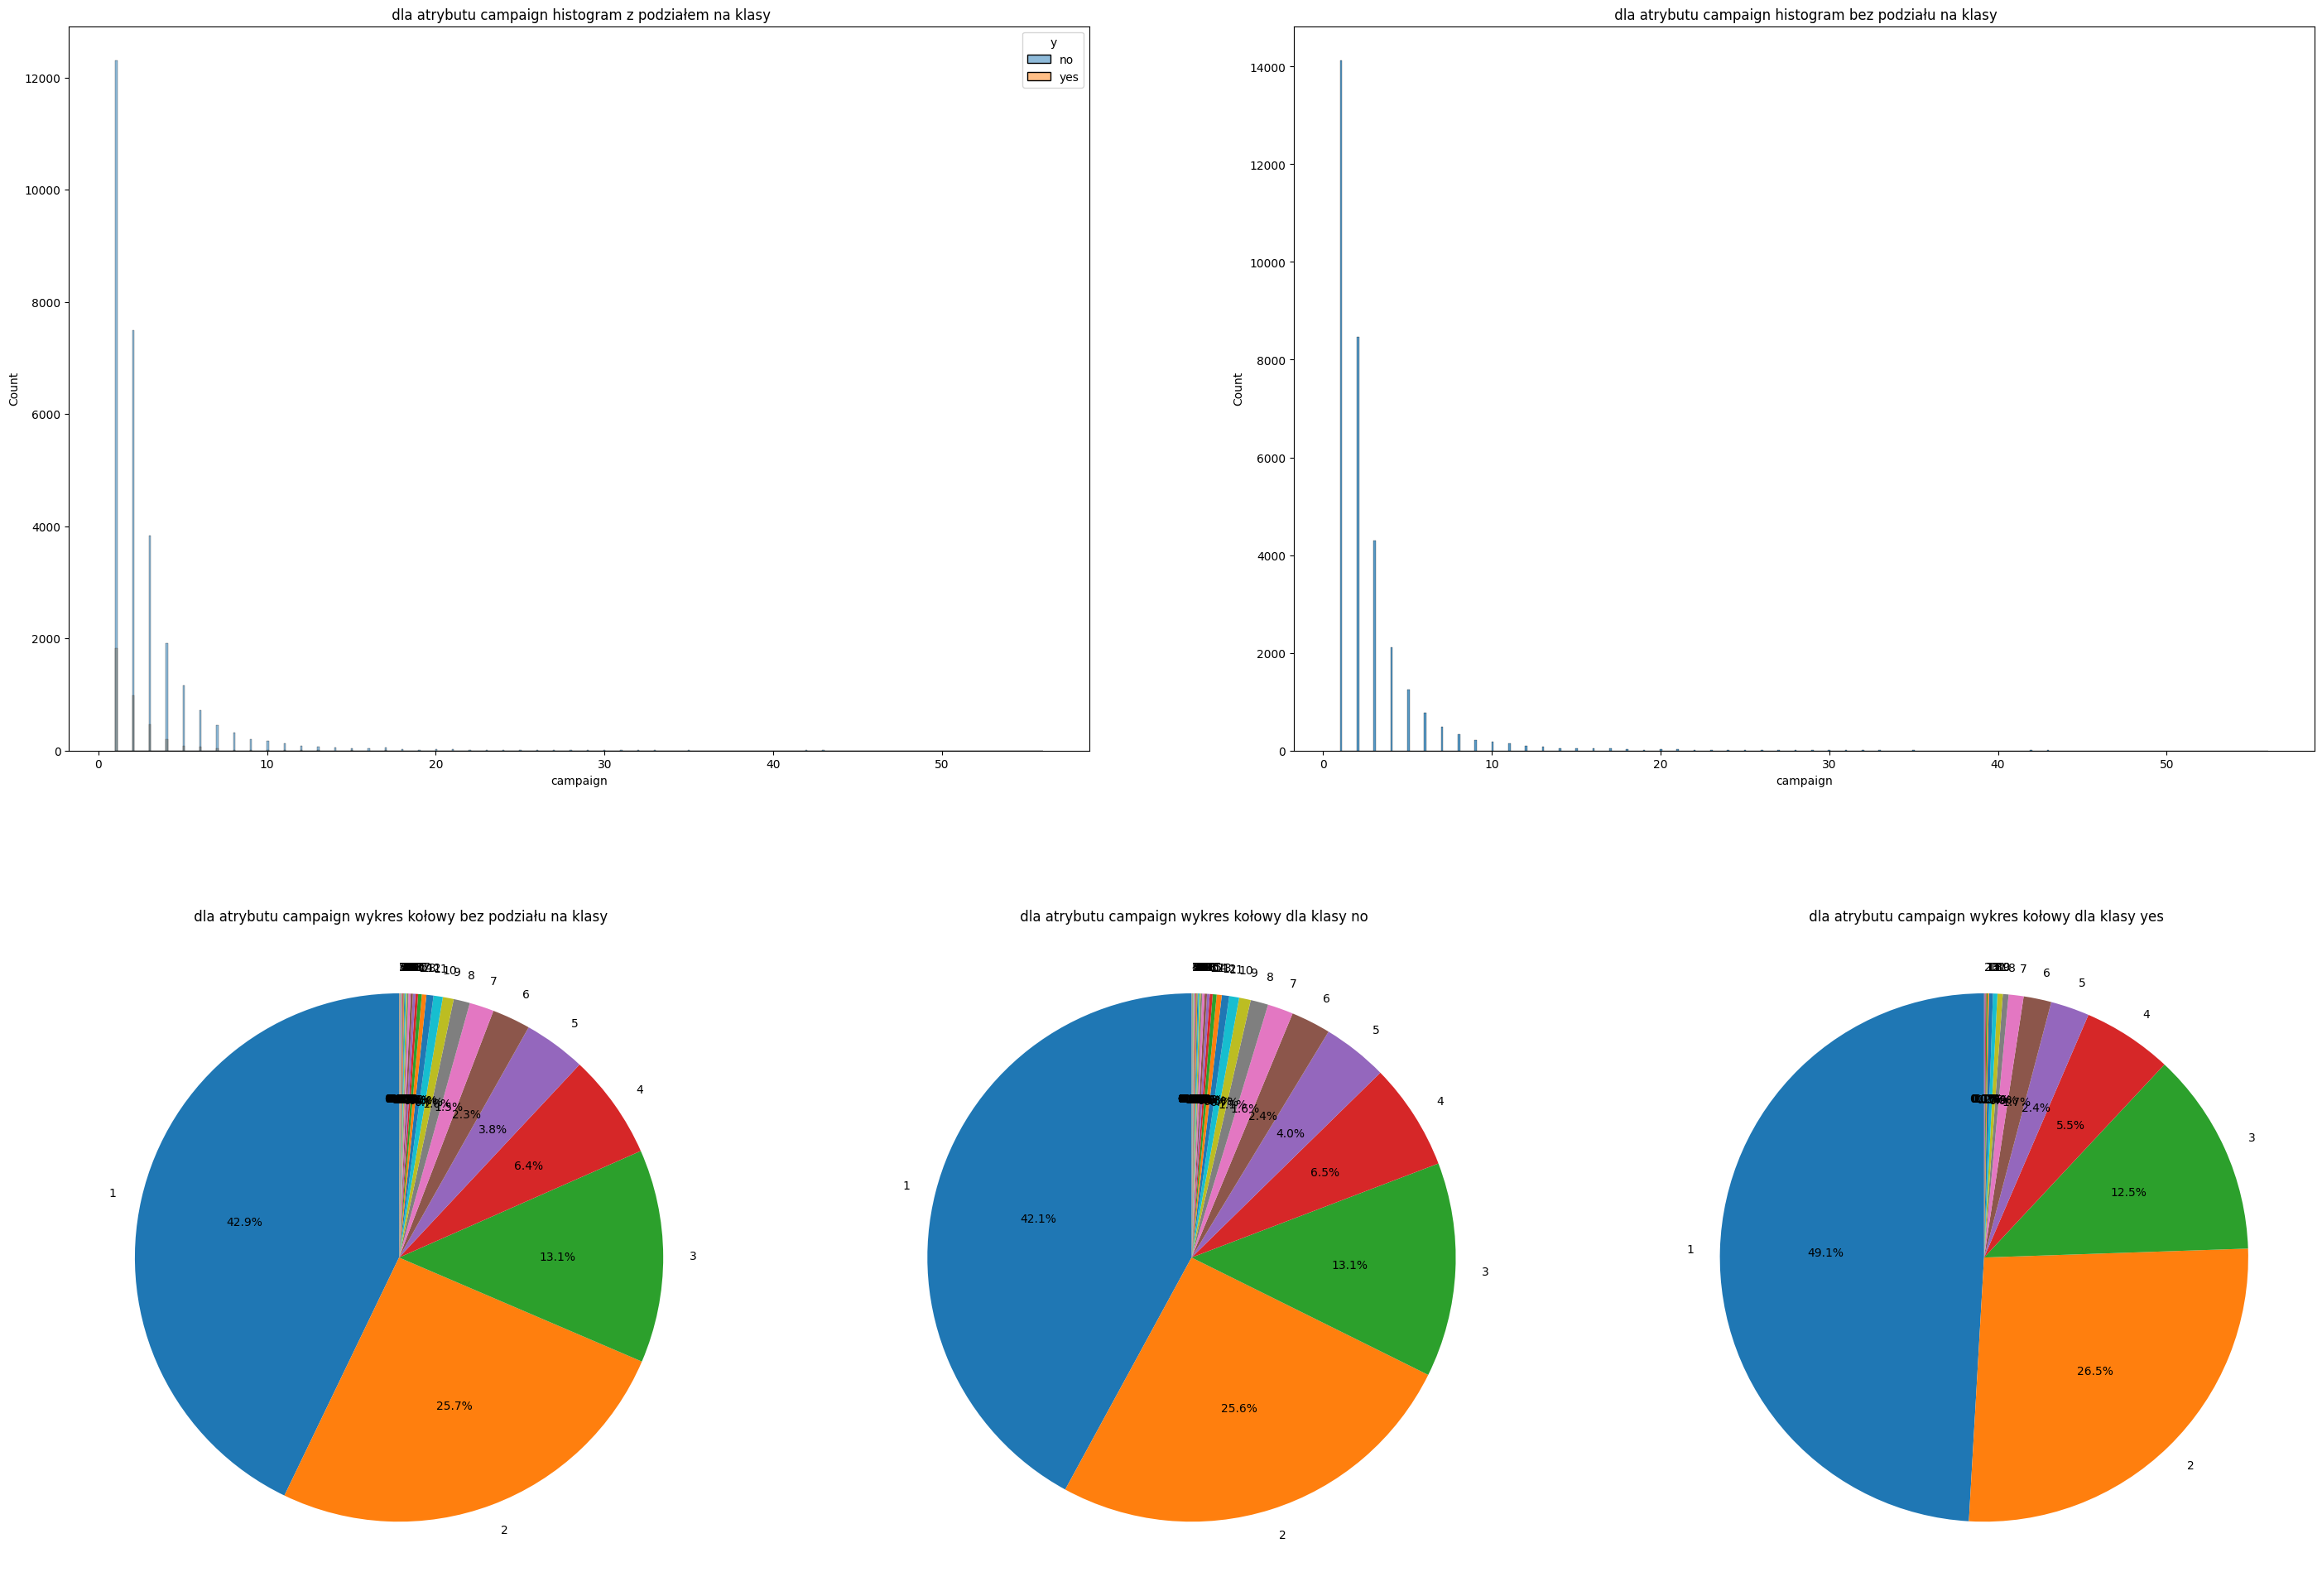

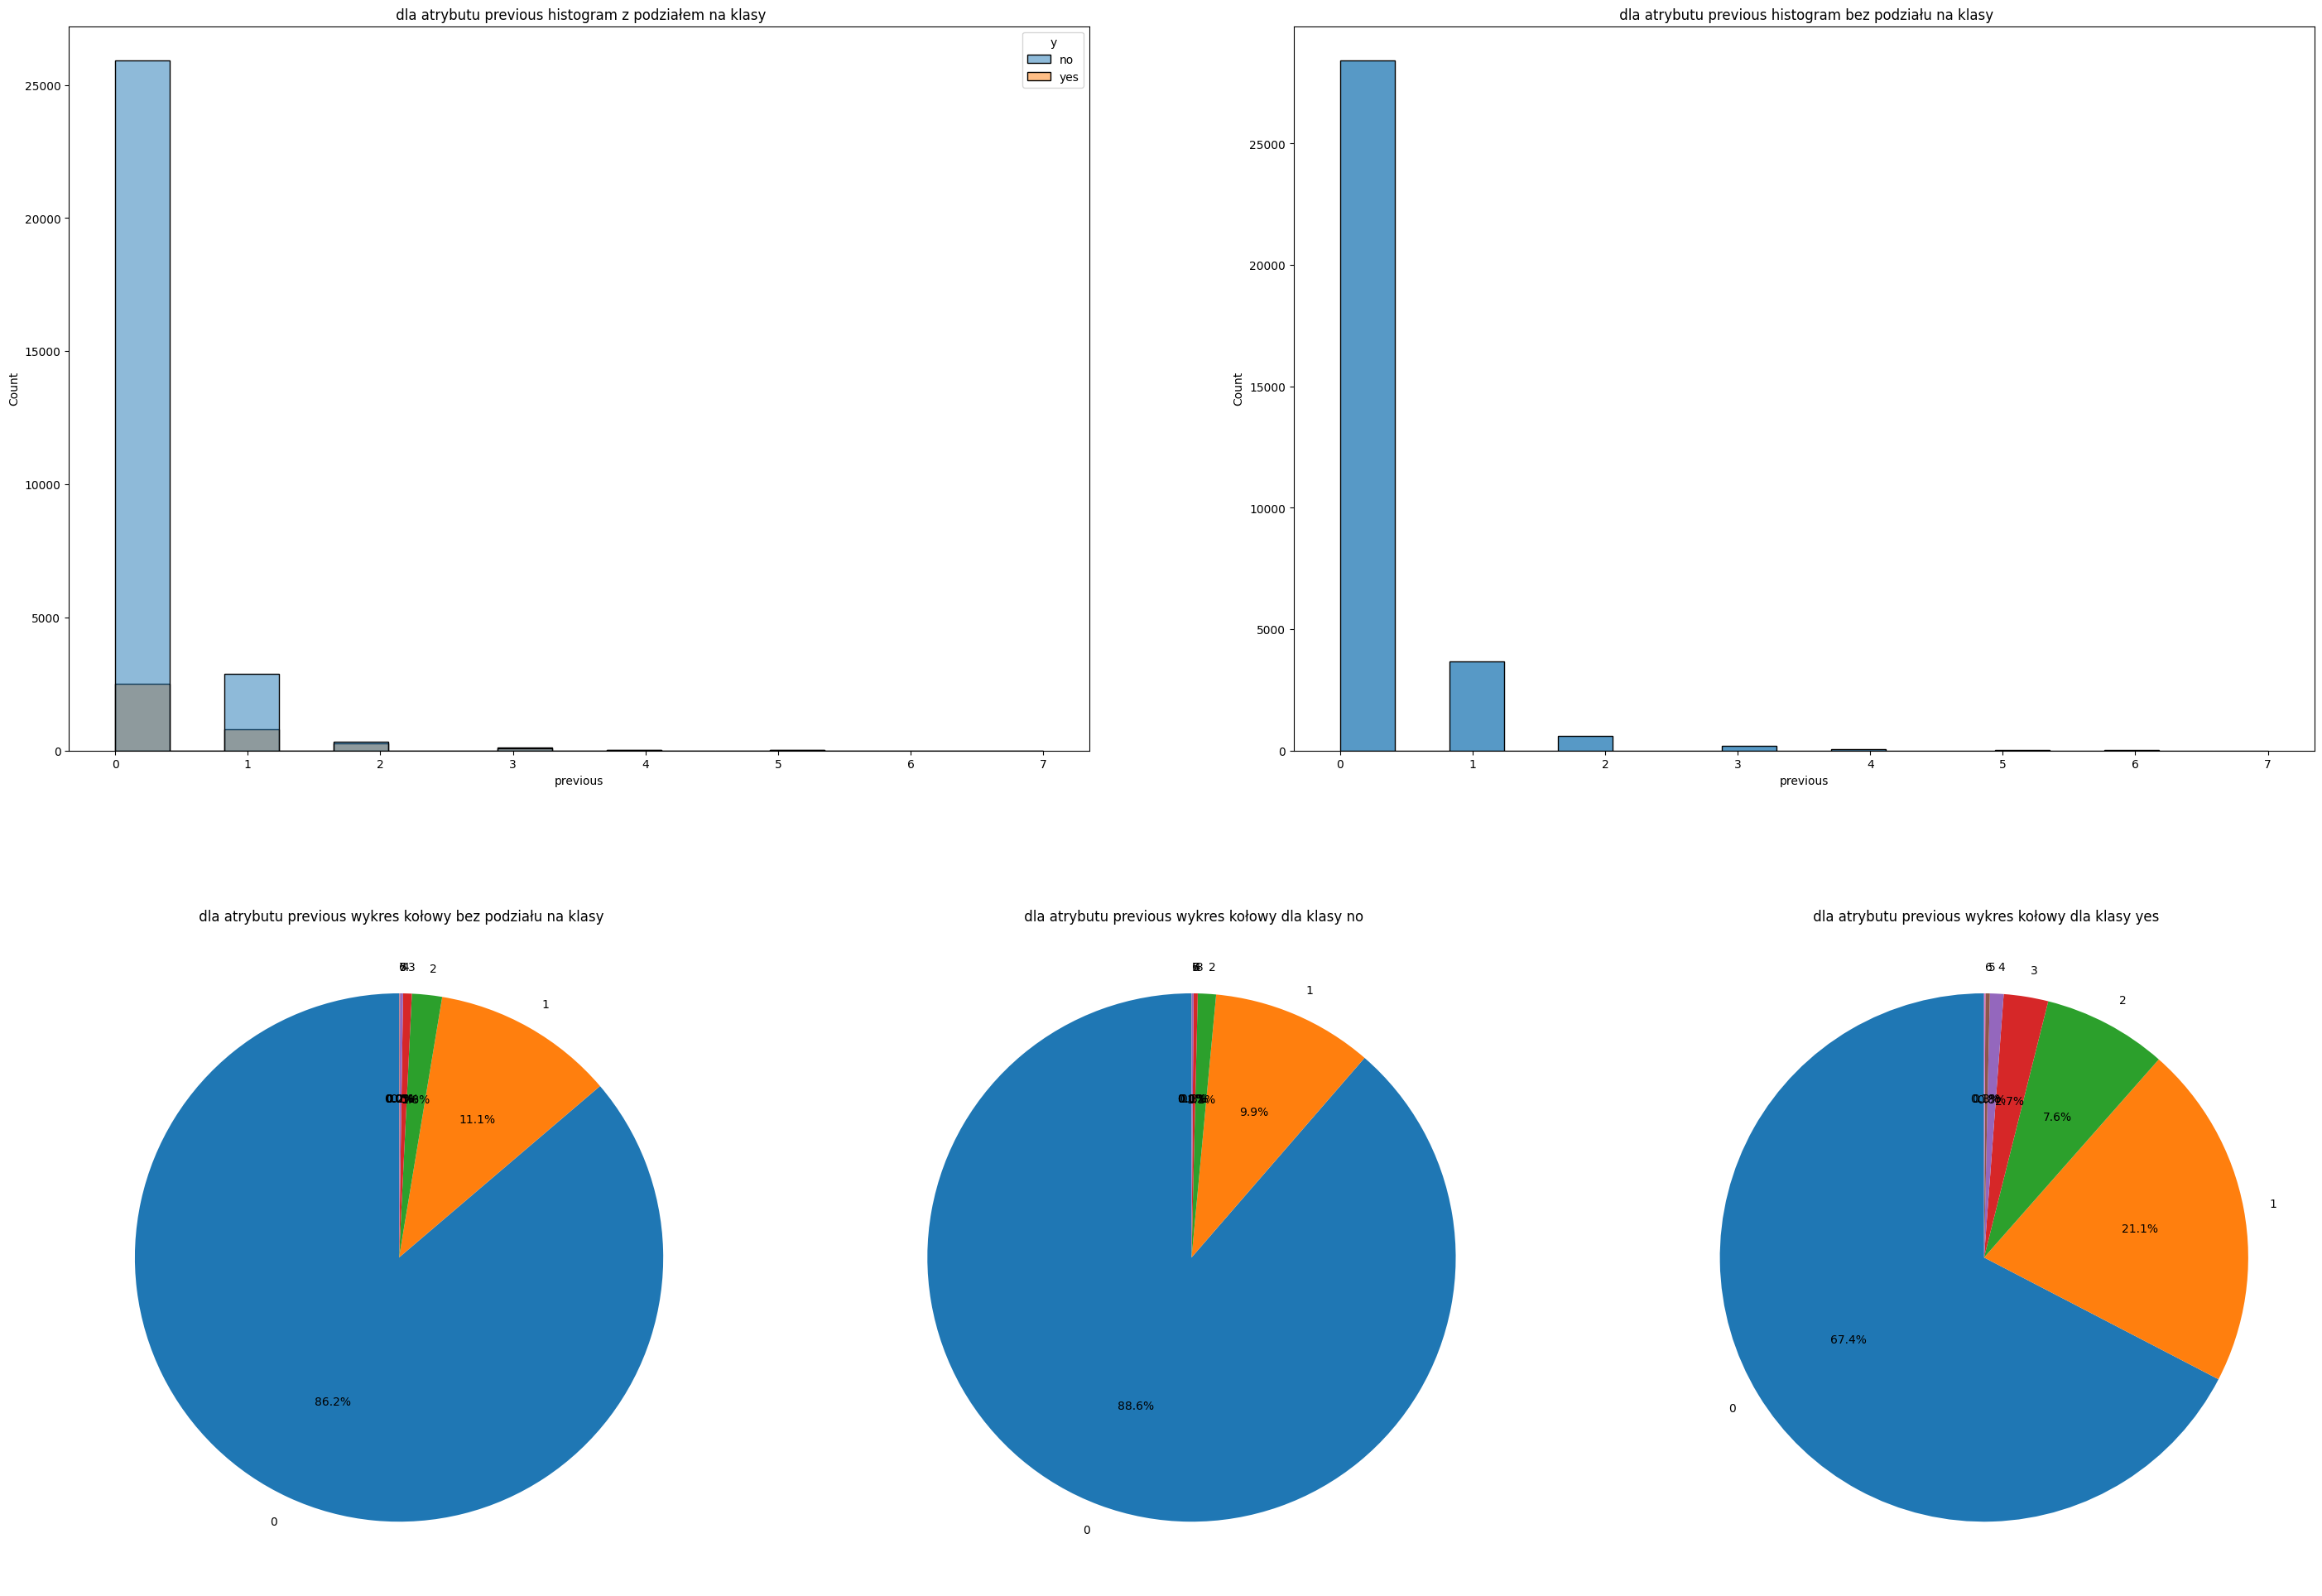

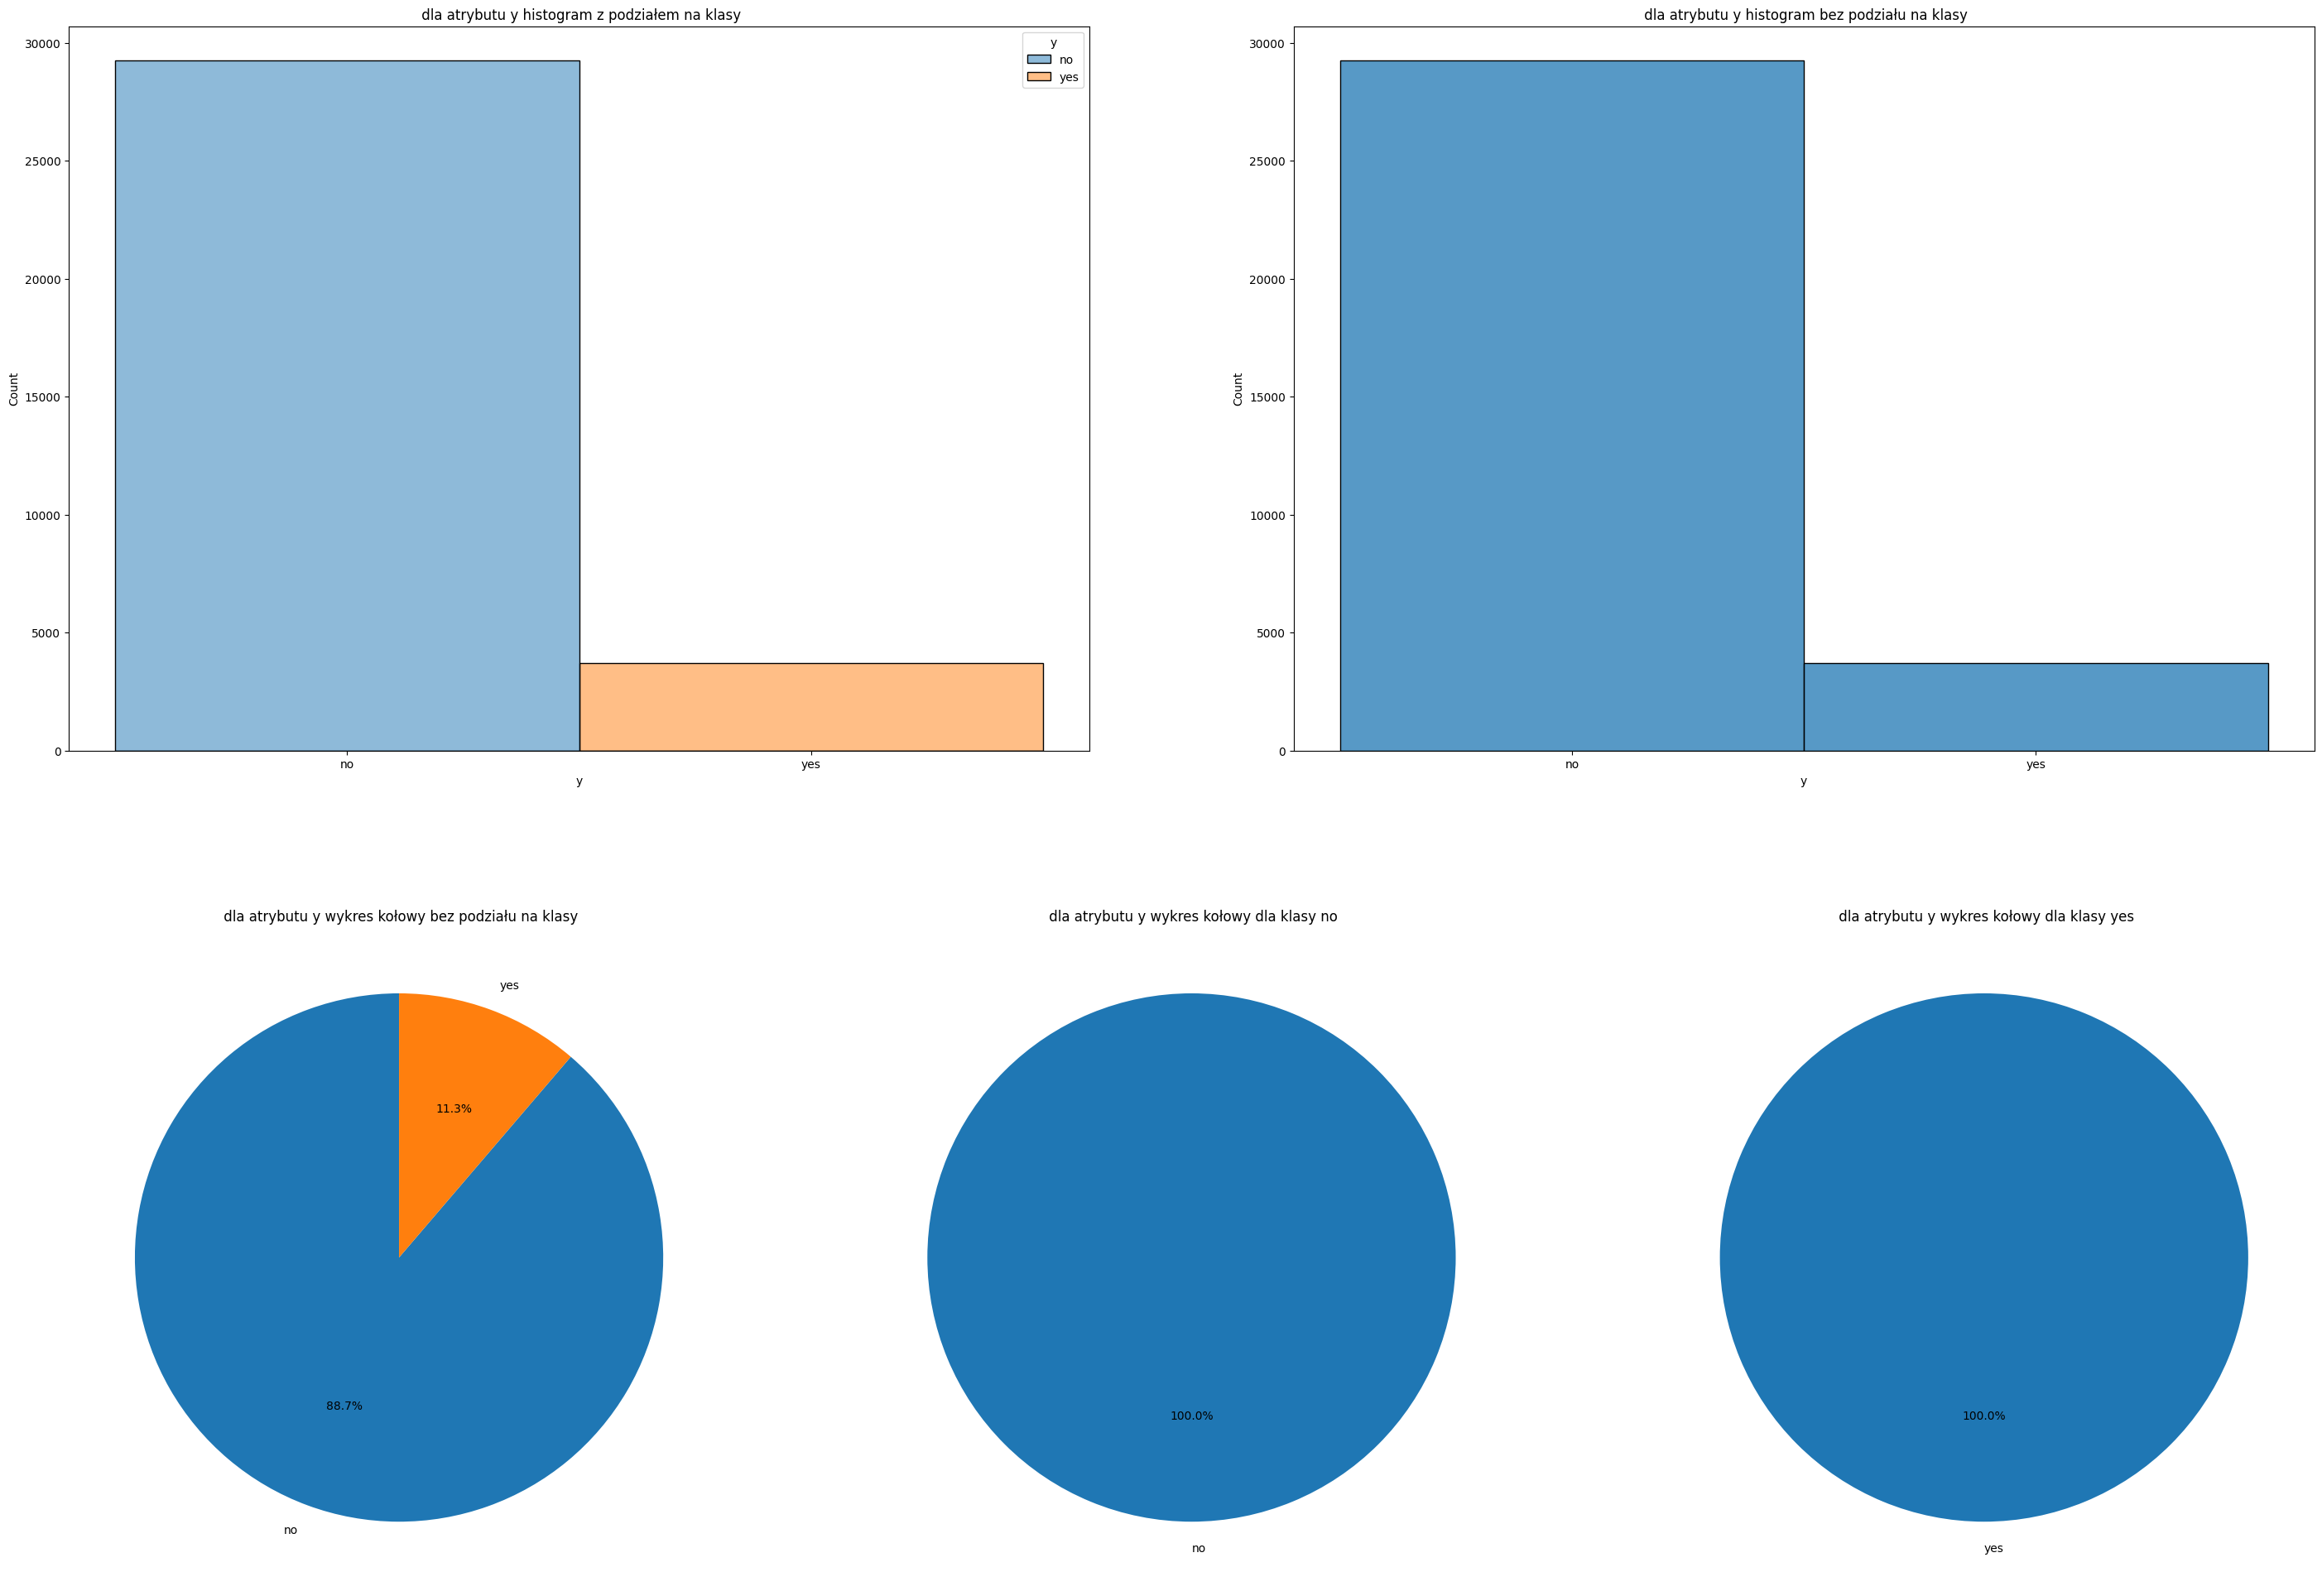

In [7]:
klasy = dftrain.iloc[:,-1].unique()

for j in range(0,dftrain.shape[1]):
        
        plt.figure(figsize=(35,25))
        plt.subplot(2,2,1)
        sns.histplot(data=dftrain,x=dftrain.iloc[:,j],hue='y')
        plt.title(" dla atrybutu "+dftrain.columns[j]+" histogram z podziałem na klasy")
        #sns.countplot(x=dftrain.iloc[:,j], data=dftrain,hue='y')
        #plt.subplot(1,3,2)
        plt.subplot(2,3,4)
        value_counts = dftrain.iloc[:, j].value_counts()
        plt.pie(value_counts, labels=value_counts.index,autopct='%1.1f%%',startangle=90)
        plt.title(" dla atrybutu "+dftrain.columns[j]+" wykres kołowy bez podziału na klasy")
        
        plt.subplot(2,3,5)
        tmp = dftrain[dftrain.iloc[:,-1]=='no']
        value_counts = tmp.iloc[:, j].value_counts()
        plt.pie(value_counts, labels=value_counts.index,autopct='%1.1f%%',startangle=90)
        plt.title(" dla atrybutu "+dftrain.columns[j]+" wykres kołowy dla klasy no")

        plt.subplot(2,3,6)
        tmp = dftrain[dftrain.iloc[:,-1]=='yes']
        value_counts = tmp.iloc[:, j].value_counts()
        plt.pie(value_counts, labels=value_counts.index,autopct='%1.1f%%',startangle=90)
        plt.title(" dla atrybutu "+dftrain.columns[j]+" wykres kołowy dla klasy yes")

        plt.subplot(2,2,2)
        sns.histplot(data=dftrain,x=dftrain.iloc[:,j])
        plt.title(" dla atrybutu "+dftrain.columns[j]+" histogram bez podziału na klasy")
        #plt.tight_layout()



In [8]:
tmp=(dftrain.iloc[:,0]==30)
print((dftrain[tmp].iloc[:,-1]=='no').sum()/(dftrain[tmp].iloc[:,-1]=='yes').sum())
#kod do pierwszego wniosku

7.53125


1. Histogramy potwierdzają, że im większy wiek tym większa szansa na to, że klient będzie chętny dla age>=65 ilość osób chętnych i niechętnych jest podobna, gdy dla np. wieku 30 lat ilość niechętnych jest 7.5 razy większa niż niechętnych

2. Warto zauważyć, że dla atrybutu contact jeżeli kontaktujemy się przez telefon komórkowy to jest większa szansa, że klient będzie chętny niż jeżeli będziemy chcieli kontaktowac się przez telefon stacjonarny.

3. Jest większa szansa, że singiel będzie zainteresowany niż osoba w małżeństwie

4. W zbiorze uczącym dla czasu rozmowy powyżej 800 sekund większość osób jest zainteresowana niż niezainteresowana

5. Atrybuty day_of_week, housing, loan nie mają realnego wpływu na klasyfikacje, ponieważ rozkład procentowy na wykresie kołowym dla tych 3 atrybutów w każdej klasie jest bardzo podobny, więc moim zdaniem te atrybuty można usunąć

6. W zbiorze uczącym ilość osób w klasie 'no' stanowi 88,7%, gdy w klasie 'yes' wynosi 11,3%





In [9]:
#usuwam dane, ze względu na wniosek 5
dftrain.drop(columns=['day_of_week', 'housing', 'loan'], inplace=True)
dftest.drop(columns=['day_of_week', 'housing', 'loan'], inplace=True)



# 3. **Uczenie Maszynowe**


Do przewidywania czy klient zainwestuje długoterminowo, użyjemy drzewa decyzyjnego.

Na początku podzielimy zbiór danych na zbiór treningowy i testowy. Musimy również zadbać o transformację naszych atrybutów kategorycznych na formę liczbową. Jest to potrzebne do dalszego uczenia maszynowego, ponieważ klasa DecisionTreeClassifier nie operuje na danych tekstowych. Jesteśmy natomiast świadomi, że te dane pozostają danymi kategorycznymi tylko na potrzeby uczenia przyporządkowany im jest jakiś kod liczbowy.

In [10]:
from sklearn.calibration import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


X = dftrain.drop(columns="y")
y = dftrain["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Ilosc obiektow treningowych: {X_train.shape[0]}")
print(f"Ilosc obiektow testowych: {X_test.shape[0]}")
print(f"Procent : {X_test.shape[0]/X.shape[0]}")
le = LabelEncoder()
def convert(df):
    for col in df.columns:
     # Sprawdzamy, czy kolumna jest kategoryczna
        df[col] = le.fit_transform(df[col])

convert(X_train)
convert(X_test)


Ilosc obiektow treningowych: 23065
Ilosc obiektow testowych: 9885
Procent : 0.3


Funkcja potrzebna do przewidzenia nowych wyników na bazie danych testowych(X_test) oraz do przekazania informacji o skuteczności procentowej.

In [11]:
def predictAndPrintScore(model):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #print(f'Dokładność modelu: {accuracy:.2f}')
    return accuracy
    

Aby uniknąć redundancji kodu tworzymy funkcję potrzebną do wizualizacji działania algorytmu drzewa decyzyjnego. Jest ona potrzebna, ponieważ będziemy testować klasyfikator dla różnych atrybutów.


In [12]:
from sklearn import tree
def drawTree(model,ax):
    _ = tree.plot_tree(
    model,
    feature_names= X_train.columns,
    class_names = y_train,
    filled=True,
    rounded=True,
    ax=ax)

    
    

Do uczenia maszynowego z użyciem drzewa decyzyjnego można użyć różnych parametrów:
- *max_depth* – maksymalna głębokość drzewa. Parametr ten określa maksymalną liczbę poziomów w drzewie. Jeśli ustawimy ten parametr na zbyt wysoką wartość może dojść do przeuczenia modelu(overfitting) natomiast jeśli użyjemy zbyt małej wartości dojdzie do niedouczenia modelu(underfitting), model nie będzie w stanie dobrze uchwycić złożoności danych.
- *min_samples_split* – minimalna liczba próbek wymagana do podziału węzła. Zwiększenie tej wartości sprawi, że drzewo będzie bardziej płytkie i mniej sczegółowe. Zbyt niska wartość doprowadzi do tego, że będzie za mało małych podziałów, co zwiększy ryzyko przeuczenia.
- *min_samples_leaf* – minimalna liczba próbek w liściu. Zbyt wysoka wartość niesie ryzyko, że model straci zdolność do wychwytywania lokalnych wzorców danych, co spowoduje niedouczenie. Zbyt niska wartość może oznaczać, że liście mogą zawierać pojedyncze próbki, co prowadzi do nadmiernego dopasowania do danych treningowych.
- *criterion* – Definiuje sposób mierzenia jakości podziału(np. `gini` lub `entropy`). `Gini` mierzy nieczystość węzłów a `entropy` mierzy wartość informacji podziału.

In [13]:
max_depth_list = [1,2,3]

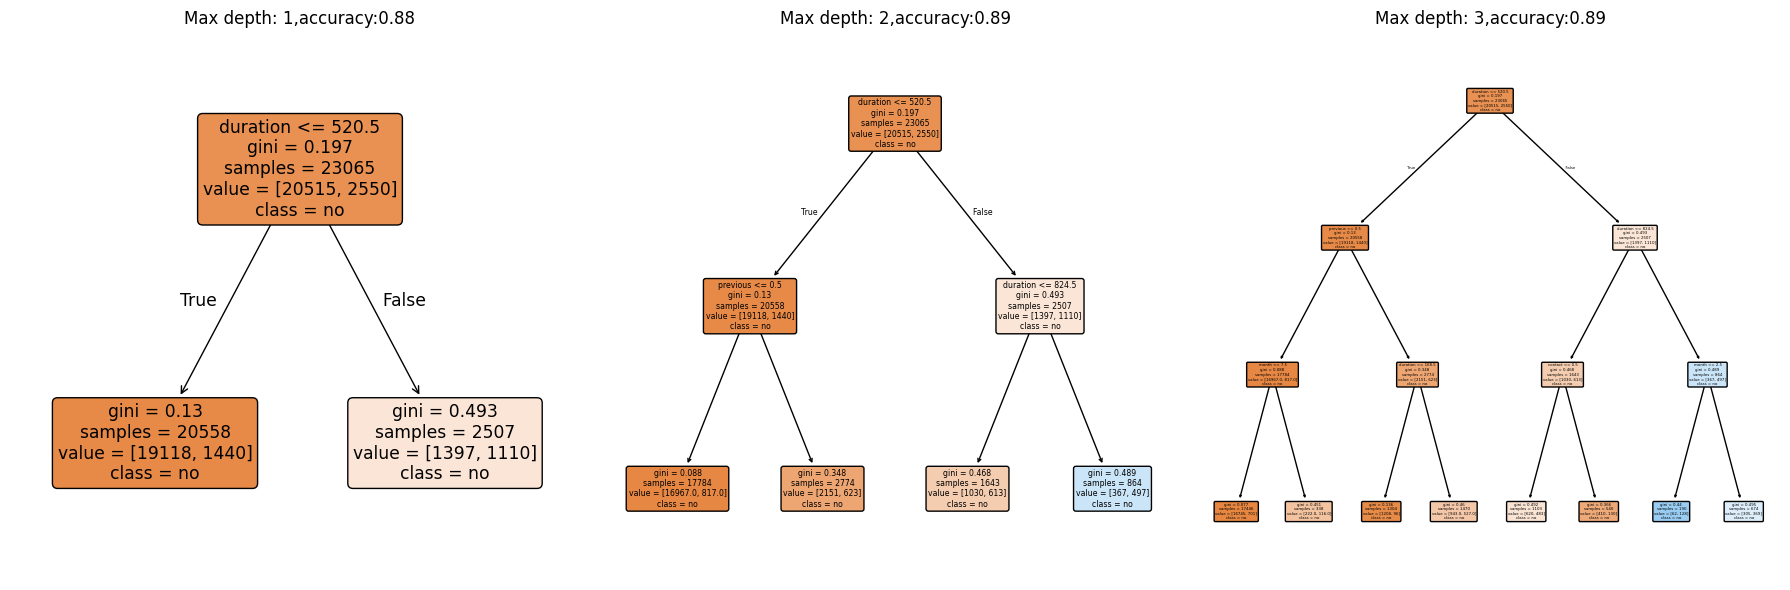

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, max_depth in enumerate(max_depth_list):
    model = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
    model.fit(X_train,y_train)
    ax = axes[i]
    drawTree(model,ax)
    accuracy = predictAndPrintScore(model)
    ax.set_title(f"Max depth: {max_depth},accuracy:{accuracy:.2f}")
plt.tight_layout()
plt.show()

Zauwazmy, ze dla max_depth = 1 model może i osiąga dużą dokładność ale zbyt upraszcza złożoność danych. Jego wysoka dokładność może wynikać z dominującej klasy `no` w zbiorze

Poniżej przetestujemy większe wartości max_depth ale ograniczymy się tylko do zapisania wyników w tablicy, ponieważ przy większych wartościach tego parametru diagram staje się nieczytelny.

In [15]:
max_depth_values = range(3, 16)
results = []

for max_depth in max_depth_values:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    accuracy = predictAndPrintScore(model)
    results.append((max_depth, accuracy))
    print(f"Max depth: {max_depth}, Accuracy: {accuracy:.2f}")

# Wybierz najlepsze max_depth
best_max_depth = max(results, key=lambda x: x[1])[0]
print(f"Najlepsza wartość max_depth: {best_max_depth}")
plt.show()

Max depth: 3, Accuracy: 0.89
Max depth: 4, Accuracy: 0.89
Max depth: 5, Accuracy: 0.90
Max depth: 6, Accuracy: 0.90
Max depth: 7, Accuracy: 0.90
Max depth: 8, Accuracy: 0.90
Max depth: 9, Accuracy: 0.90
Max depth: 10, Accuracy: 0.89
Max depth: 11, Accuracy: 0.89
Max depth: 12, Accuracy: 0.89
Max depth: 13, Accuracy: 0.89
Max depth: 14, Accuracy: 0.88
Max depth: 15, Accuracy: 0.88
Najlepsza wartość max_depth: 8


Do dalszego uczenia użyjmy `max_depth`=8

Zobaczmy dla jakich wartości `min_samples_split` drzewo będzie osiągać najlepszą skuteczność. 

In [16]:
min_samples_split_values = [2, 5, 10, 20, 50]
results = []
for min_samples_split in min_samples_split_values:
    model = DecisionTreeClassifier(max_depth=8, random_state=42,min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    accuracy = predictAndPrintScore(model)
    results.append((min_samples_split, accuracy))
    print(f"Min samples split: {min_samples_split}, Accuracy: {accuracy:.2f}")

Min samples split: 2, Accuracy: 0.90
Min samples split: 5, Accuracy: 0.90
Min samples split: 10, Accuracy: 0.90
Min samples split: 20, Accuracy: 0.90
Min samples split: 50, Accuracy: 0.90


Zauważmy, że do wartości `min_samples_split = 10` skuteczność modelu utrzymuje się w miarę na tym samym poziomie a dla wyższych wartości zgodnie z teorią drzewo staje się mniej szczegółowe.

Kontynujemy uczenie z drzewem o paremetrach `max_depth=12`, `min_samples_split=10`

In [17]:
min_samples_leaf_values=[1, 2, 5, 10, 20, 50]
results = []
for min_samples_leaf in min_samples_leaf_values:
    model = DecisionTreeClassifier(max_depth=8, random_state=42,min_samples_split=900,min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    accuracy = predictAndPrintScore(model)
    results.append((min_samples_leaf, accuracy))
    print(f"min_samples_leaf: {min_samples_leaf}, Accuracy: {accuracy:.2f}")

min_samples_leaf: 1, Accuracy: 0.90
min_samples_leaf: 2, Accuracy: 0.90
min_samples_leaf: 5, Accuracy: 0.90
min_samples_leaf: 10, Accuracy: 0.90
min_samples_leaf: 20, Accuracy: 0.90
min_samples_leaf: 50, Accuracy: 0.90


Zauważalny jest spadek skuteczności przy większych wartościach `min_samples_leaf`. Model staje się bardziej ogólny ale traci na dokładności. Przy `min_samples_leaf=1` model dobrze generalizuje.

Na koniec zobaczmy czy duży wpływ na nasz model ma sposób mierzenia jakości podziału.

In [18]:
criterion_list = ["gini",'entropy']
results = []
for criterion in criterion_list:
    model = DecisionTreeClassifier(random_state=42,max_depth=8,min_samples_split=10,min_samples_leaf=50,criterion=criterion)
    model.fit(X_train,y_train)
    accuracy = predictAndPrintScore(model)
    results.append((criterion, accuracy))
    print(f"criterion: {criterion}, Accuracy: {accuracy:.2f}")

criterion: gini, Accuracy: 0.90
criterion: entropy, Accuracy: 0.90


Kryterium gini, które skupia się na mierzeniu czystości klas osiąga lepszy wynik niż mierzenie entropii dla tego zbioru.

Sprawdźmy jeszcze inne klasyfikatory

In [28]:

model = GaussianNB()
model.fit(X_train,y_train)
accuracy = predictAndPrintScore(model)
print(f"Dokładność dla klasyfikacji Bayesa: {accuracy:.2f}")

model = NearestCentroid()
model.fit(X_train,y_train)
accuracy = predictAndPrintScore(model)
print(f"Dokładność dla klasyfikacji najbliższego centroidu: {accuracy:.2f}")

Neighbours=range(1,100,5)
results = []
for i in Neighbours:
    model = KNeighborsClassifier(i)
    model.fit(X_train,y_train)
    accuracy = predictAndPrintScore(model)
    results.append((i, accuracy))
    #print(f"Ilość sąsiadów: {min_samples_leaf}, Accuracy: {accuracy:.2f}")
best_model = max(results, key=lambda x: x[1])
best_Kneighbours, best_accuracy=best_model
print(f"Najlepsza wartość dla ilości sąsiadów: {best_Kneighbours}, Accuracy: {best_accuracy:.2f}")

Dokładność dla klasyfikacji Bayesa: 0.89
Dokładność dla klasyfikacji najbliższego centroidu: 0.82
Najlepsza wartość dla ilości sąsiadów: 61, Accuracy: 0.89


Z powyższego kodu można wyczytać, że:
1. Dokładność klasyfikacji Bayesa i K najbliższych sąsiadów dla K=61 mają dokładność 0.89, które jest bardzo bliskie dokładności drzewa decyzyjnego

2. klasyfikacja nabliższego centroidu ma dokładność 0.82, czyli ten model nie jest dobry w tym zadaniu

# 4. **WNIOSKI**


1. Tak jak podejrzewaliśmy w fazie eksploracji danych drzewo decyzyjne jest najlepsze co potwierdziliśmy w fazie uczenia nadzorowanego uzyskując dokładność 0.90

2. Jesteśmy zaskoczeni wynikiem klasyfikatora Bayesa i Knajbliższych sąsiadów dla których dokładność wynosi 0.89
